In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.16590996/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# c1

## Column density ratios

Enter measurements for species

In [14]:
logN_dict = {'HI':'16.1, -0.1, +0.1',
            'HeI':'14.6, -0.1, +0.1',
            'CIII':'13.8, -0.2, +0.3',
            'CIV':'13.50, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.06, +0.08',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.73, -0.08, +0.06',
            'OVI':'<13.6',
            'NeVIII':'<13.6',
            'MgII':'<15.4',
            'MgX':'<13.7',
            'AlII':'<11.0',
            'AlIII':'<11.5',
            'SiII':'<12.1',
            'SiIII':'12.65, -0.07, +0.07',
            'FeII':'<11.6',}

In [15]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OIV'])

'-0.64, -0.09, 0.07'

In [16]:
logN_ratio_dict = {'HeI/HI':'-1.50, -0.13, 0.13',
                   'SiIII/OIII': '-1.54, -0.1, 0.1',
                   'OIV/OIII': '0.19, -0.08, 0.08',
                   'OV/OIV': '-0.67, -0.11, 0.11'}
                   #'OVI/OV': '<-0.1, 0.2'}

(-2.6, 1.0)

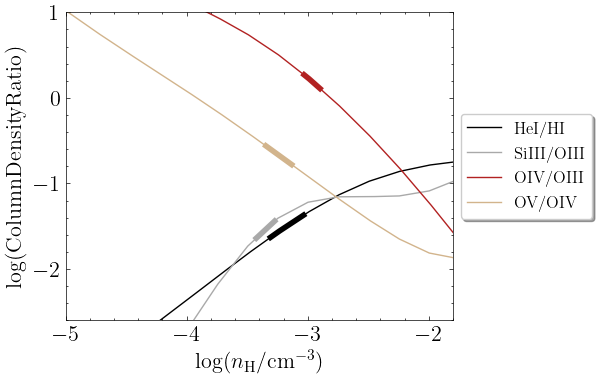

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.6, 1.)

## Single phase solution

In [47]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O}])
    
    return log_prior(params_full)

In [48]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [49]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [50]:
logN_dict = {'HI':'16.1, -0.1, +0.1',
            'HeI':'14.6, -0.1, +0.1',
            'CIII':'13.8, -0.2, +0.3',
            'CIV':'13.50, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.06, +0.08',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.73, -0.08, +0.06',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            'MgII':'<15.4',
            #'MgX':'<13.7',
            #'AlII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.1',
            'SiIII':'12.65, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [51]:
logN_HI_test = 16.1
log_hdens_test = -3.2
log_metals_test = -1.85
C_O_test = -0.2

In [52]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test}))

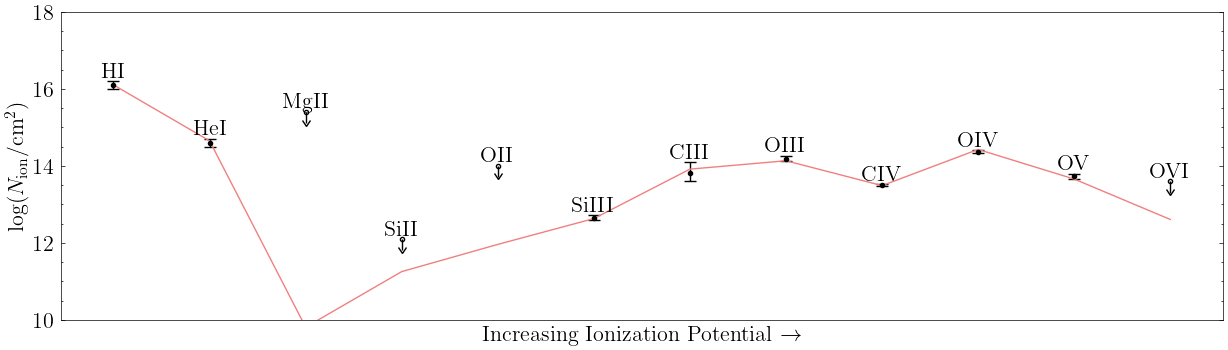

In [53]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [54]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test]) + 1e-7 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape

In [55]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [56]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [01:58<00:00,  4.23it/s]


In [57]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals', 'C_O'])
flat_samples.to_csv(savedir+'one_phase_c1.csv', index=False)

#flat_samples = pd.read_csv(savedir+'one_phase_c1.csv')

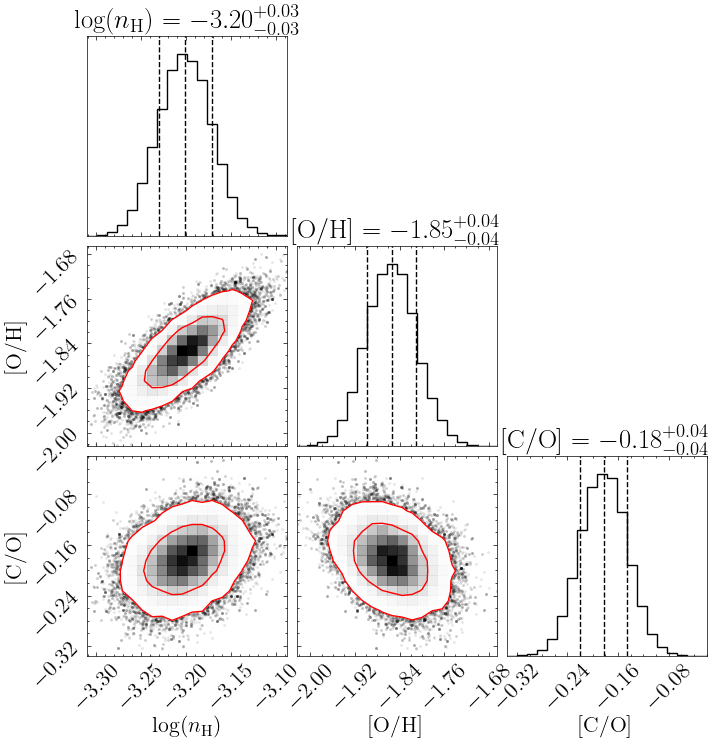

In [58]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [59]:
np.median(flat_samples['log_metals'])

-1.854362531726085

Now plot the best models

In [60]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            'HeI':'14.6, -0.1, +0.1',
            'CIII':'13.8, -0.2, +0.3',
            'CIV':'13.50, -0.02, +0.02',
            #'OII':'<14.0',
            'OIII':'14.18, -0.06, +0.08',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.73, -0.08, +0.06',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<15.4',
            #'MgX':'<13.7',
            #'AlII':'<11.0',
            #'AlIII':'<11.5',
            'SiII':'<12.1',
            'SiIII':'12.65, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [61]:
b_dict = {'HI':'19, -3, +2',
          'HeI':'12, -1, +1',
          'CIII': '10.6, -0.4, +0.4',
          'CIV': '10.6, -0.4, +0.4',
          'OIII': '14, -3, +3',
          'OIV': '16, -2, +2',
          'OV': '11, -3, +3',
          'SiIII': '11, -2, +3'}

In [62]:
z_sys = 1.16590996

In [63]:
import matplotlib.lines as mlines

In [64]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O'])})

In [65]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [66]:
logN_res_up = {k:'<0.9' for k in list(logN_res_dict.keys())}

logN_res_up['SiII'] = '<0.45'
logN_res_up['OVI'] = '<0.45'

In [67]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O']})

In [68]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

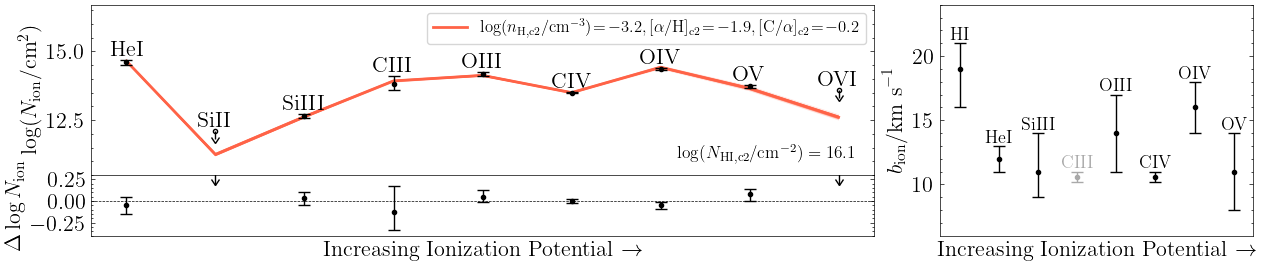

In [69]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['NeVIII'])

axd['upper left'].set_ylim(10.5,16.7)

axd['upper left'].text(len(logN_dict)-.8, 11.1, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 16.1$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2}/\mathrm{cm}^{-3}) \!=\! -3.2, \mathrm{[\alpha/H]_{c2}} \!=\! -1.9, \mathrm{[C/\alpha]_{c2}}\!=\!-0.2$'))

axd['upper left'].legend(handles=handles, loc='upper right', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['NeVIII'], label_ions=False)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['NeVIII'], label_ions=False, c_dy=1.3)

axd['lower left'].set_ylim(-.4,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], gray_out = ['CIII'], fs=13)
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(6,24)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [70]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

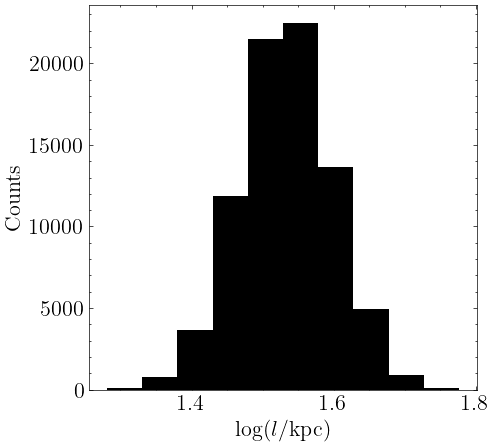

In [71]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [72]:
get_quantiles(np.log10(l))

1.53 -0.07 0.07


# c2

## Column density ratios

Enter measurements for species

In [14]:
logN_dict = {'HI':'14.7, -0.2, +0.2',
            'HeI':'<13.9',
            'CIII':'<13.1',
            'CIV':'13.02, -0.06, +0.06',
            'OII':'<14.0',
            'OIII':'<13.4',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'13.83, -0.06, +0.06',
            'OVI':'13.9, -0.1, +0.1',
            'NeVIII':'<13.7',
            'MgII':'<15.6',
            'MgX':'<13.8',
            'AlII':'<11.2',
            'AlIII':'<11.7',
            'SiII':'<12.3',
            'SiIII':'<12.1',
            'FeII':'<11.8',}

Get column density ratios

In [15]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OVI'])

'-0.07, -0.12, 0.12'

In [16]:
logN_ratio_dict = {#'HeI/HI': '<-1.80, 0.24',
                   #'OIII/OIV': '<-0.4, 0.2',
                   #'NeVIII/OVI': '<-0.20, 0.17',
                   'OV/OIV': '-0.07, -0.12, 0.12',
                   'OV/OVI': '-0.07, -0.12, 0.12',
  }
                   #'OVI/OV': '<0.1, 0.2'}

Generate predicted column density ratios

(-2.2, 2.0)

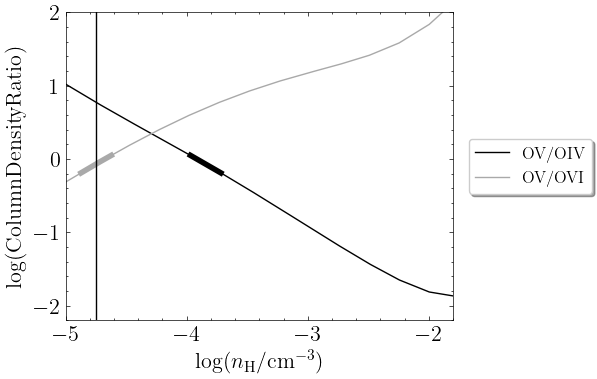

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)
ax.axvline(-4.75)
ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2)

## Single phase solution

In [18]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O}])
    
    return log_prior(params_full)

In [19]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [20]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [21]:
logN_dict = {#'HI':'14.7, -0.2, +0.2',
            'HeI':'<13.9',
            'CIII':'<13.1',
            'CIV':'13.02, -0.06, +0.06',
            'OII':'<14.0',
            'OIII':'<13.4',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'13.83, -0.06, +0.06',
            #'OVI':'13.9, -0.1, +0.1',
            #'NeVIII':'<13.7',
            'MgII':'<15.6',
            #'MgX':'<13.8',
            #'AlII':'<11.2',
            #'AlIII':'<11.7',
            'SiII':'<12.3',
            'SiIII':'<12.1',}
            #'FeII':'<11.8',}

In [22]:
logN_HI_test = 14.7
log_hdens_test = -3.9
log_metals_test = -1.7
C_O_test = 0.07

In [23]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test}))

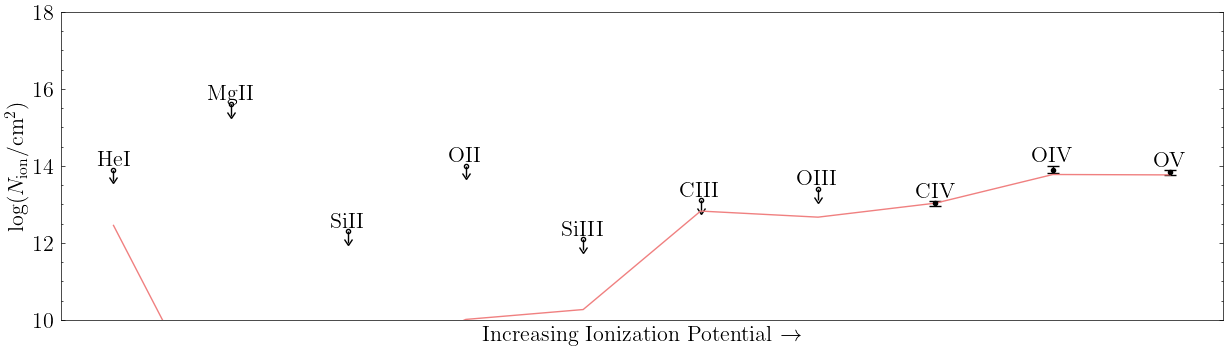

In [24]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [25]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test]) + 1e-7 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape

In [26]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [27]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [01:55<00:00,  4.33it/s]


In [28]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals', 'C_O'])
flat_samples.to_csv(savedir+'one_phase_c2.csv', index=False)

#flat_samples = pd.read_csv(savedir+'one_phase_c2.csv')

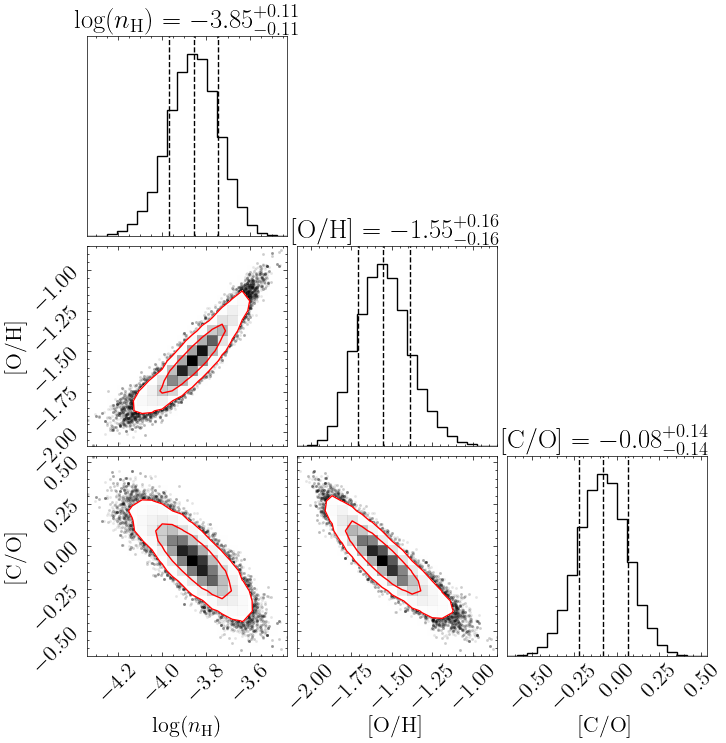

In [29]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [30]:
np.median(flat_samples['log_hdens'])

-3.8544504401952775

In [31]:
np.median(flat_samples['log_metals'])

-1.5508367295229397

In [32]:
np.median(flat_samples['C_O'])-np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig)),np.percentile(flat_samples['C_O'], 100*cdf_1sig)- np.median(flat_samples['C_O'])

(0.14403753841017394, 0.14480043332746606)

Now plot the best models

In [33]:
logN_dict = {#'HI':'14.7, -0.2, +0.2',
            'HeI':'<13.9',
            'CIII':'<13.1',
            'CIV':'13.02, -0.06, +0.06',
            #'OII':'<14.0',
            'OIII':'<13.4',
            'OIV':'13.9, -0.1, +0.1',
            'OV':'13.83, -0.06, +0.06',
            'OVI':'13.9, -0.1, +0.1',}
            #'NeVIII':'<13.7',
            #'MgII':'<15.6',
            #'MgX':'<13.8',
            #'AlII':'<11.2',
            #'AlIII':'<11.7',
            #'SiII':'<12.3',
            #'SiIII':'<12.1',}
            #'FeII':'<11.8',}

In [34]:
b_dict = {'HI':'31, -3, +3',
          'CIV': '27, -3, +3',
          'OIV': '28, -6, +8',
          'OV': '29, -3, +2',
          'OVI': '45, -11, +15'}

In [35]:
z_sys = 1.16590996

In [36]:
import matplotlib.lines as mlines

In [37]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O'])})

In [38]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [39]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['HeI'] = '<0.3'
logN_res_up['OIII'] = '<0.3'
logN_res_up['OVI'] = '<0.3'

In [40]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O']})

In [41]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

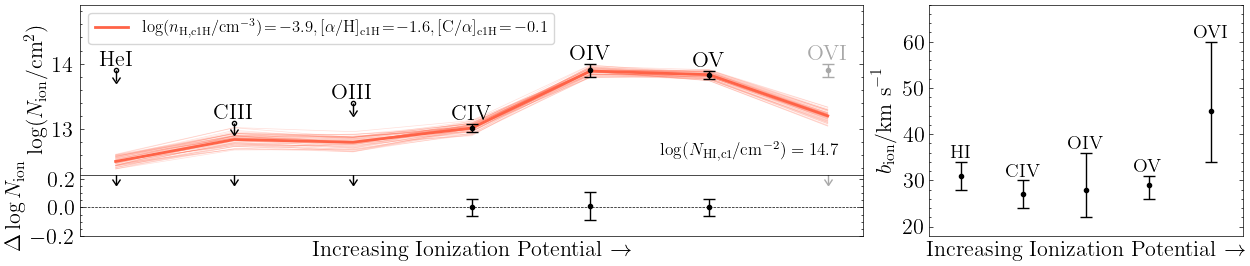

In [42]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI'], dy=.1, c_dy=1.7)

axd['upper left'].set_ylim(12.3,14.9)

axd['upper left'].text(len(logN_dict)-.9, 12.6, 
             r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.7$', fontsize=12.5,
             horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) \!=\! -3.9, \mathrm{[\alpha/H]_{c1H}} \!=\! -1.6, \mathrm{[C/\alpha]_{c1H}}\!=\!-0.1$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0) 

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.1, c_dy=1.4)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.1, c_dy=1.4)

axd['lower left'].set_ylim(-.2,.23)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=14)
axd['right'].set_xlim(-0.5, len(b_dict)-1+.5)
axd['right'].set_ylim(18,68)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [43]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

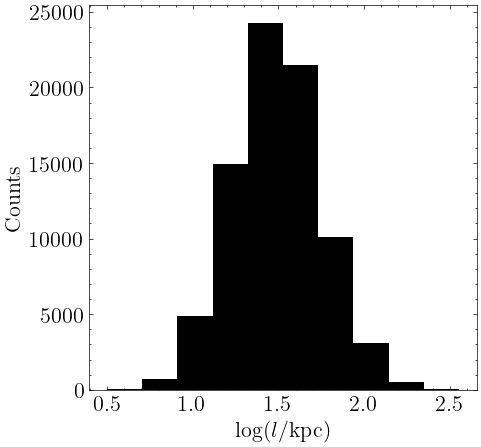

In [44]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [45]:
get_quantiles(np.log10(l))

1.49 -0.25 0.26


In [46]:
np.median(np.log10(l))-np.percentile(np.log10(l), 100*(1-cdf_1sig)),np.percentile(np.log10(l), 100*cdf_1sig)- np.median(np.log10(l))

(0.2547537007078724, 0.257589631690877)

In [126]:
np.log10(40*(10**-4./10**-3)**-0.5),

(2.1020599913279625,)

# DRAFT

# c1 - Single phase solution

In [106]:
gen_logN_ratio_str(logN_dict['OV'], logN_dict['OIV'])

'0.04, -0.11, 0.11'

In [19]:
logN_ratio_dict = {'OIV/OIII': '0.19, -0.08, 0.08',
                   'OV/OIV': '-0.67, -0.11, 0.20'}

(-2.2, 2.5)

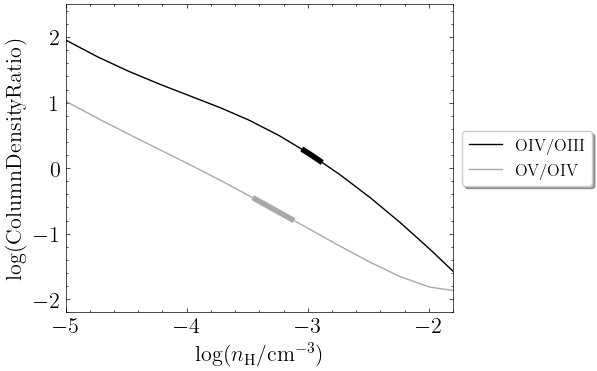

In [20]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

In [21]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [22]:
pos = np.array(-3) + 1e-4 * np.random.randn(500, 1)
nwalkers, ndim = pos.shape

In [23]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [24]:
#sampler.run_mcmc(pos, 500, progress=True);

In [25]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_op.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_op.csv')

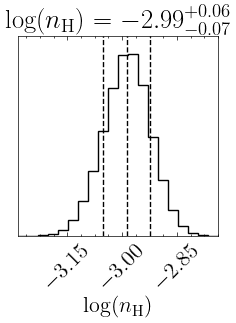

In [26]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [27]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [28]:
logN_offset = 14.18-np.mean(species_logN_interp['O+2'](grid_points_hdens))

Calculate C/O ratio

In [29]:
logN_CIV_obs = np.random.normal(loc=13.49, scale=0.02, size=len(flat_samples_hdens))

In [30]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [31]:
get_quantiles(C_O_dist)

-0.1 -0.1 0.11


Calculate Si/O ratio

In [32]:
logN_SiIII_obs = np.random.normal(loc=12.65, scale=0.07, size=len(flat_samples_hdens))

In [33]:
Si_O_dist_SiIII = logN_SiIII_obs-(logN_offset+species_logN_interp['Si+2'](grid_points_hdens))
Si_O_dist = Si_O_dist_SiIII

In [34]:
get_quantiles(Si_O_dist)

-0.3 -0.07 0.07


Get yields

In [35]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

14.18 -0.03 0.02


Plot models

In [36]:
logN_dict = {#'HI':'16.4, -0.1, +0.1',
            #'HeI':'14.61, -0.09, +0.09',
            'CIII':'>13.5',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<13.6',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.2',
            'OVI':'<13.3',
            #'NeVIII':'<13.3',
            #'MgII':'<14.0',
            #'MgX':'<13.4',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'12.65, -0.07, +0.07',}
            #'FeII':'<11.4'}

In [37]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

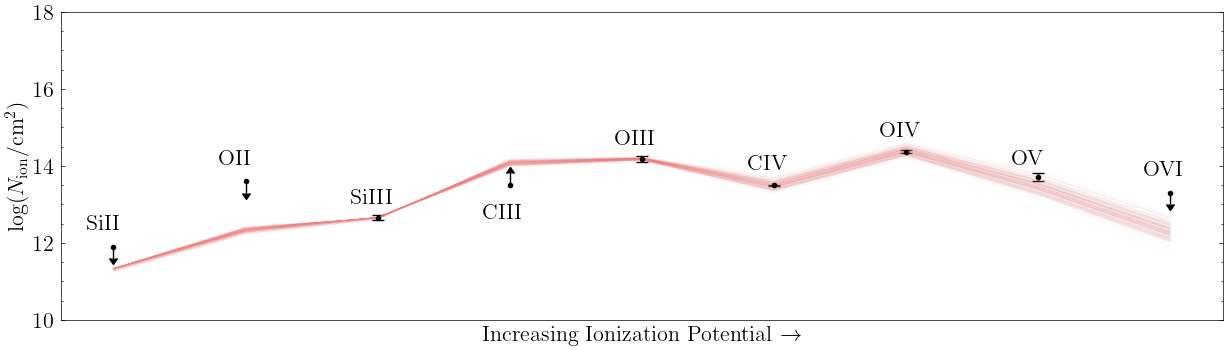

In [38]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist), 'Si': np.median(Si_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='lightcoral', lw=.2, alpha=.1)

# c1 - Two-phase solution

In [39]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [40]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [41]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [42]:
logN_dict = {#'HI':'16.4, -0.1, +0.1',
            #'HeI':'14.61, -0.09, +0.09',
            #'CIII':'>13.5',
            #'CIV':'13.49, -0.02, +0.02',
            'OII':'<13.6',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.2',
            'OVI':'<13.3',
            #'NeVIII':'<13.3',
            #'MgII':'<14.0',
            #'MgX':'<13.4',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',}
            #'SiIII':'12.65, -0.07, +0.07',
            #'FeII':'<11.4'}

In [43]:
logN_HI_test_p1 = 16.4
log_hdens_test_p1 = -1.5
log_metals_test_p1 = -1.8

logN_HI_test_p2 = 15.3
log_hdens_test_p2 = -3.1
log_metals_test_p2 = -0.8

In [44]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

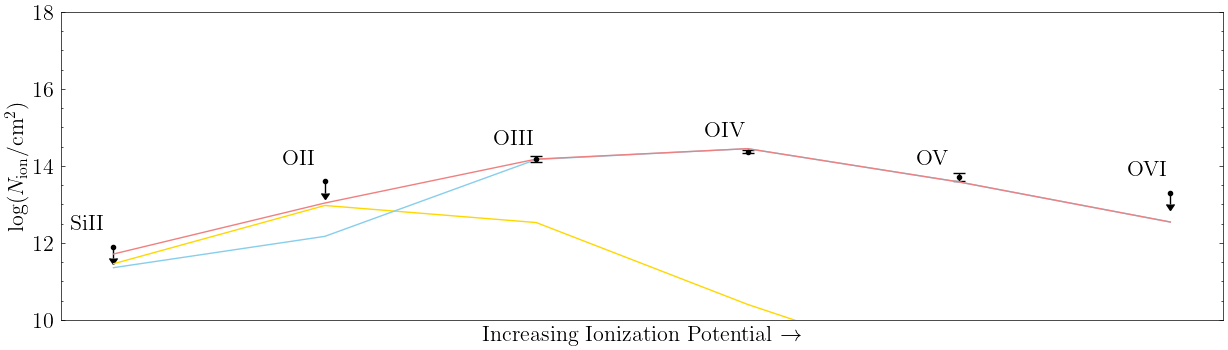

In [45]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [46]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-6 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [47]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [48]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [49]:
#sampler.run_mcmc(pos, 500, progress=True);

In [50]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c1.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c1.csv')

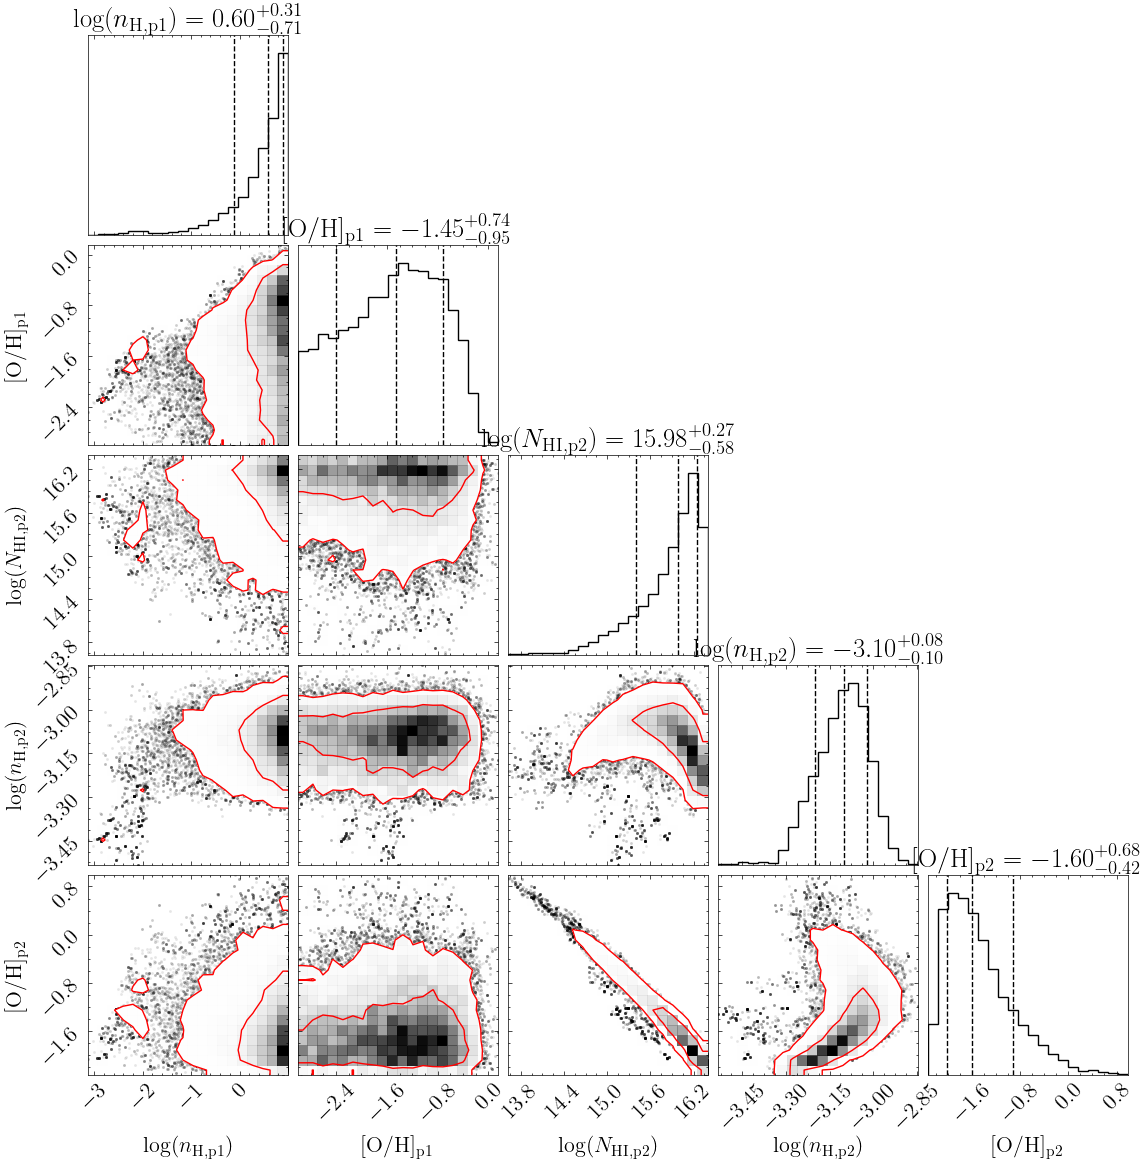

In [51]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [52]:
logN_dict = {#'HI':'16.4, -0.1, +0.1',
            'HeI':'14.61, -0.09, +0.09',
            'CIII':'>13.5',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<13.6',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.2',
            'OVI':'<13.3',
            #'NeVIII':'<13.3',
            #'MgII':'<14.0',
            #'MgX':'<13.4',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'12.65, -0.07, +0.07',}
            #'FeII':'<11.4'}

In [53]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

(10.0, 16.0)

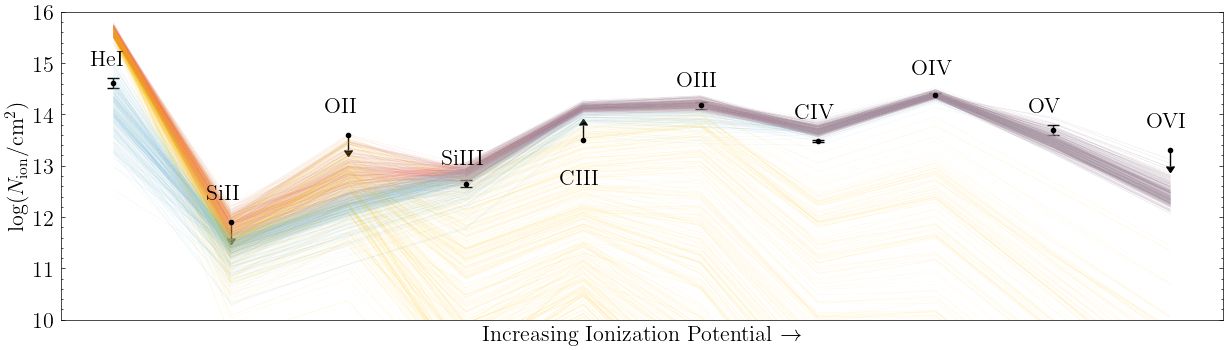

In [54]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

Get cloud sizes

In [56]:
l_p1 = np.zeros(len(flat_samples_two_phase))
l_p2 = np.zeros(len(flat_samples_two_phase))

In [57]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

Text(0, 0.5, 'Counts')

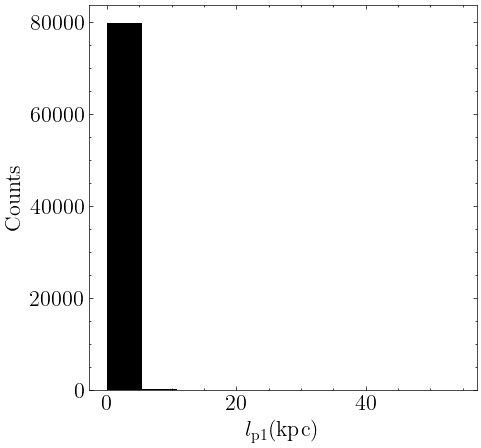

In [58]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [59]:
np.percentile(l_p1, 100*cdf_3sig)

9.694779939854048

Text(0, 0.5, 'Counts')

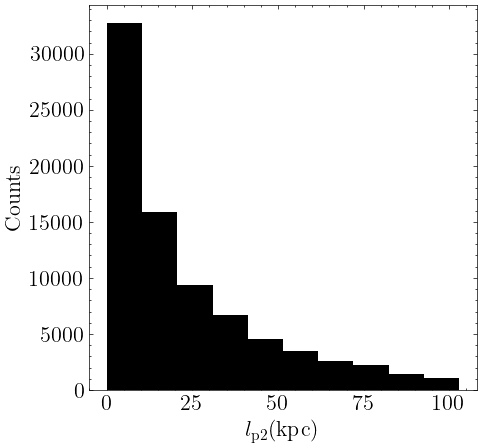

In [60]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [61]:
np.percentile(l_p2, 100*cdf_3sig)

101.67863078010903

# c1 - Two-phase solution: high density phase

In [55]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            #'HeI':'14.60, -0.09, +0.09',
            #'CIII':'>13.2',
            #'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'13.8, -0.2, +0.1',
            'OIV':'<14.37',}
            #'OV':'13.7, -0.1, +0.1',
            #'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<12.1',
            #'SiIII':'12.64, -0.07, +0.07',
            #'FeII':'<11.6',}

In [57]:
gen_logN_ratio_str(logN_dict['OII'], logN_dict['OIII'])

'<0.20, 0.17'

In [58]:
logN_ratio_dict = {
                   'OII/OIII': '<0.2, 0.2',
                   'OIV/OIII': '<0.6, 0.2',
                   #'SiII/OIII': '<-1.9, 0.2',
                   #'SiIII/OIII': '-1.55, -0.10, 0.10'
                  }

(-5.0, 5.0)

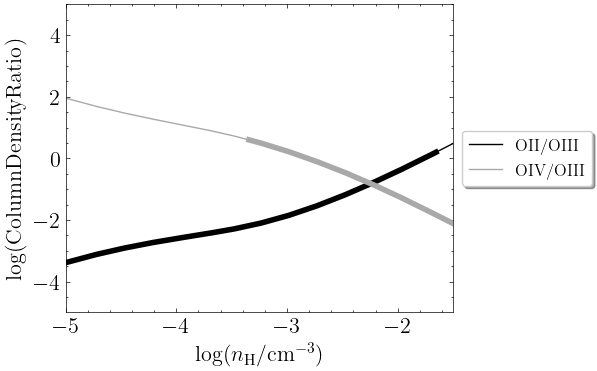

In [59]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [60]:
pos = np.array(-2.6) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [61]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [65]:
#sampler.run_mcmc(pos, 500, progress=True);

In [66]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi_c1.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi_c1.csv')

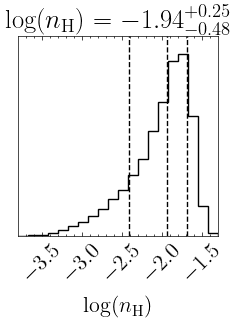

In [67]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [68]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [69]:
logN_offset = 13.8-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [70]:
logN_offset

6.041306394191182

Calculate the Si/O ratio

In [71]:
logN_SiIII_obs = np.random.normal(loc=12.64, scale=0.07, size=len(flat_samples_hdens))

In [72]:
Si_O_dist = logN_SiIII_obs-(logN_offset+species_logN_interp['Si+2'](grid_points_hdens))

In [73]:
get_quantiles(Si_O_dist)

-0.11 -0.48 0.31


Get yields

In [74]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.8 -0.47 0.59


Plot models

In [75]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            #'HeI':'14.60, -0.09, +0.09',
            #'CIII':'>13.2',
            #'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'13.8, -0.2, +0.1',
            'OIV':'<14.37',
            #'OV':'13.7, -0.1, +0.1',
            #'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',
            'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [76]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

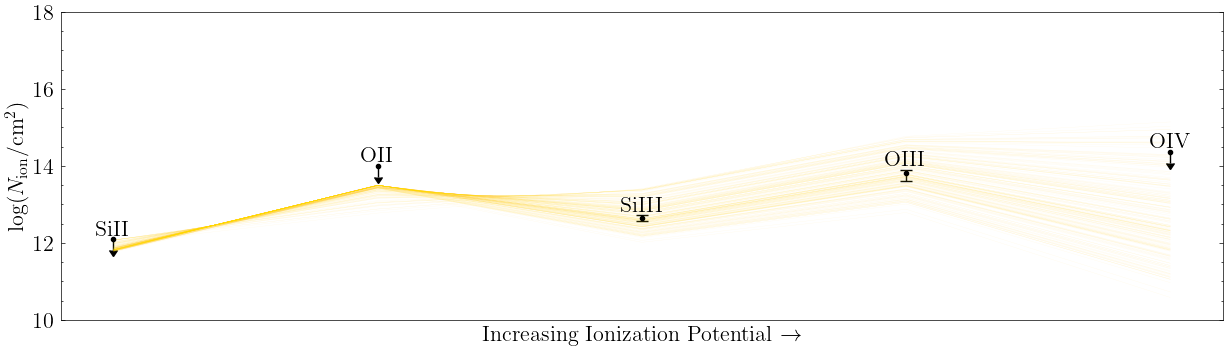

In [77]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'Si':np.median(Si_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [78]:
get_cloud_size(16.1, -1.9, species_logN_interp)

0.0571471162694283

# c1 - Two phase solution: simultaneous

In [79]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [80]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [81]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [95]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            #'HeI':'14.60, -0.09, +0.09',
            #'CIII':'>13.2',
            #'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',}
            #'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [96]:
logN_HI_test = 16.1
log_hdens_test_p1 = -2.2
log_metals_test_p1 = -1.5

logN_HI_test_p2 = 15.2
log_hdens_test_p2 = -3.4
log_metals_test_p2 = -1.2

In [97]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

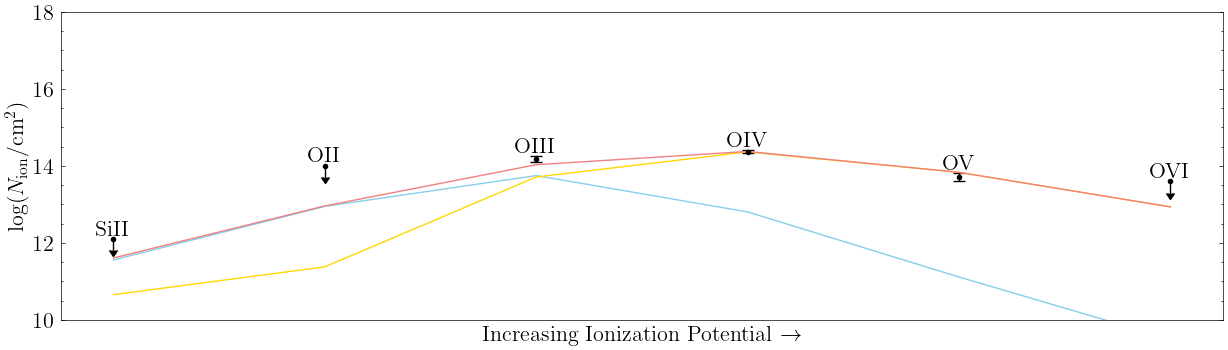

In [98]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [99]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-5 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [100]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [101]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [105]:
#sampler.run_mcmc(pos, 500, progress=True);

In [106]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c1.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c1.csv')

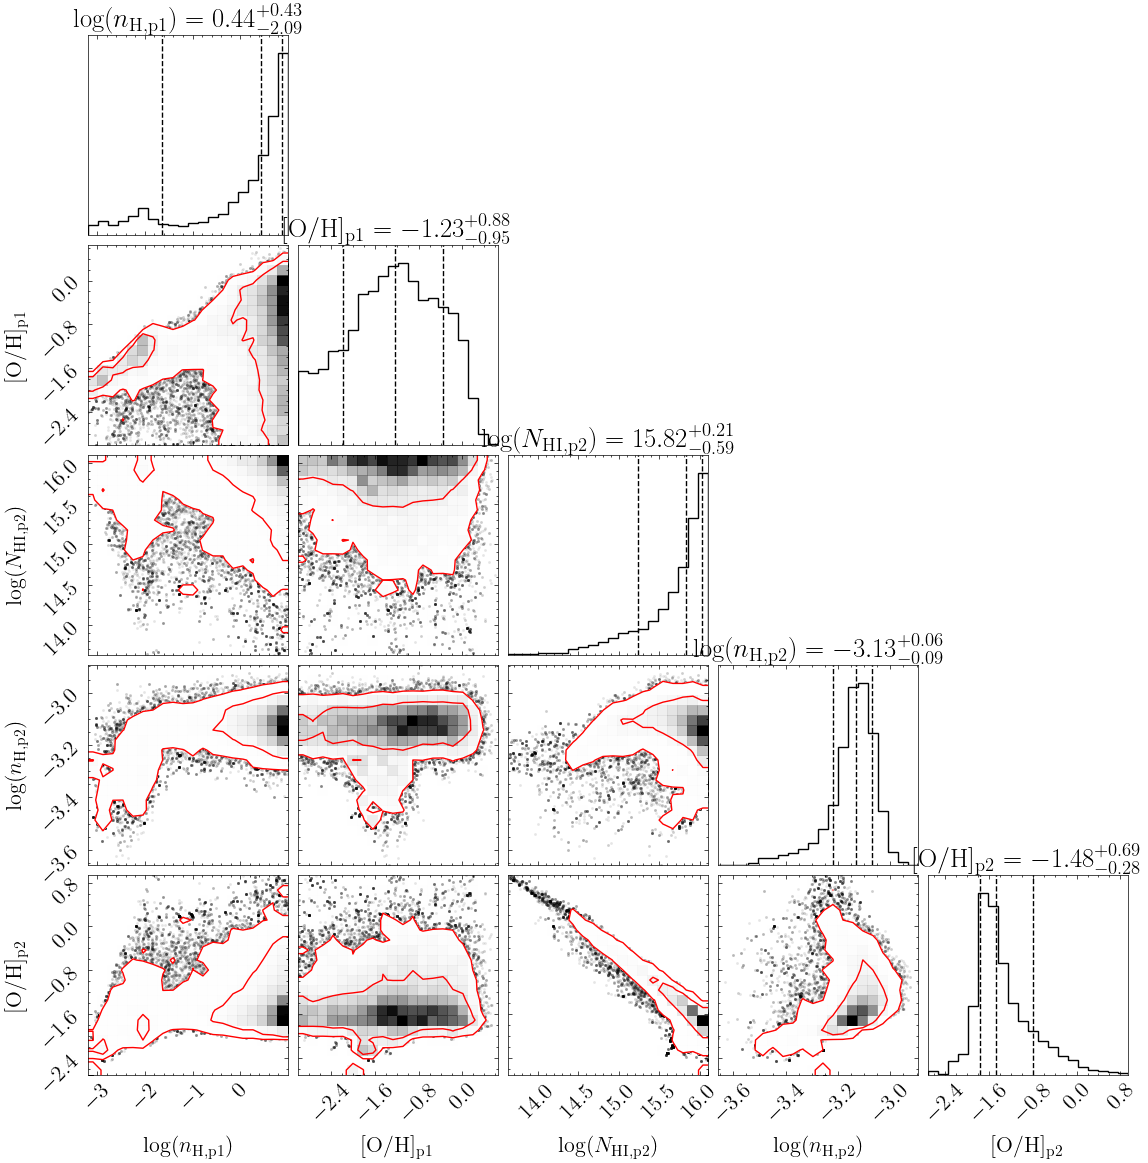

In [107]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [108]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            #'HeI':'14.60, -0.09, +0.09',
            'CIII':'>13.2',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',}
            #'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [109]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

(10.0, 16.0)

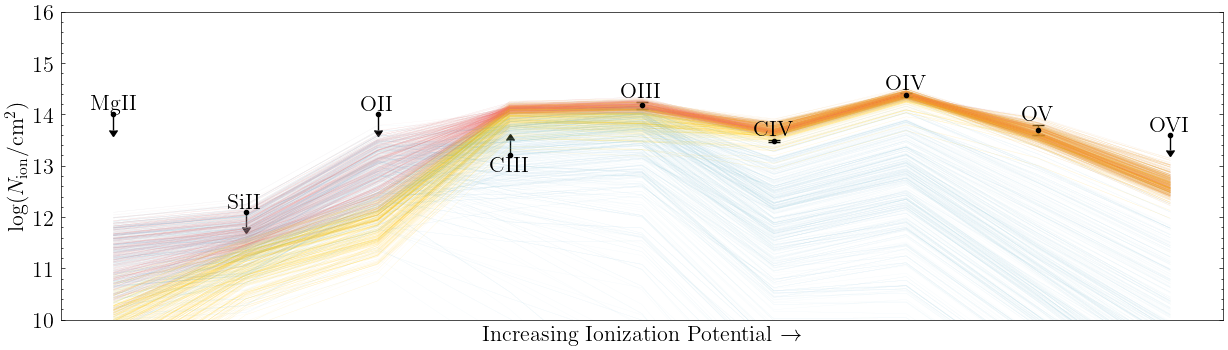

In [110]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
  
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold', lw=.2, alpha=.1)

ax.set_ylim(10,16)

Get cloud sizes

In [111]:
#l_p1 = np.zeros(len(flat_samples_two_phase))
#l_p2 = np.zeros(len(flat_samples_two_phase))

In [112]:
#for i in range(len(l_p1)):
    
#    flat_samples_row = flat_samples_two_phase.iloc[i]
    
#    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
#    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

In [113]:
#fig, ax = plt.subplots(1, figsize=(5,5))

#ax.hist(l_p1, bins=10)

#ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [114]:
#np.median(l_p1), np.percentile(l_p1, 100*cdf_3sig)

In [115]:
#fig, ax = plt.subplots(1, figsize=(5,5))

#ax.hist(l_p2, bins=10)

#ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
#ax.set_ylabel('Counts')

In [116]:
#np.median(l_p2), np.percentile(l_p2, 100*cdf_3sig)

# c1 - Two phase solution: with relative abundances

In [117]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, Si_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, Si_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'Si': Si_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'Si': Si_O_p2}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [118]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, Si_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, Si_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'Si': Si_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'Si': Si_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [119]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [215]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            'HeI':'14.60, -0.09, +0.09',
            'CIII':'>13.2',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',
            'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [241]:
logN_HI_test = 16.1
log_hdens_test_p1 = -3.3
log_metals_test_p1 = -2.0
C_O_test_p1 = 0
Si_O_test_p1 = 0

logN_HI_test_p2 = 15.1
log_hdens_test_p2 = -3.7
log_metals_test_p2 = -1.4
C_O_test_p2 = -0.2
Si_O_test_p2 = 0

In [242]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [243]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp, {'C':C_O_test_p1, 'Si':Si_O_test_p1}))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_test_p2, 'Si':Si_O_test_p2}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

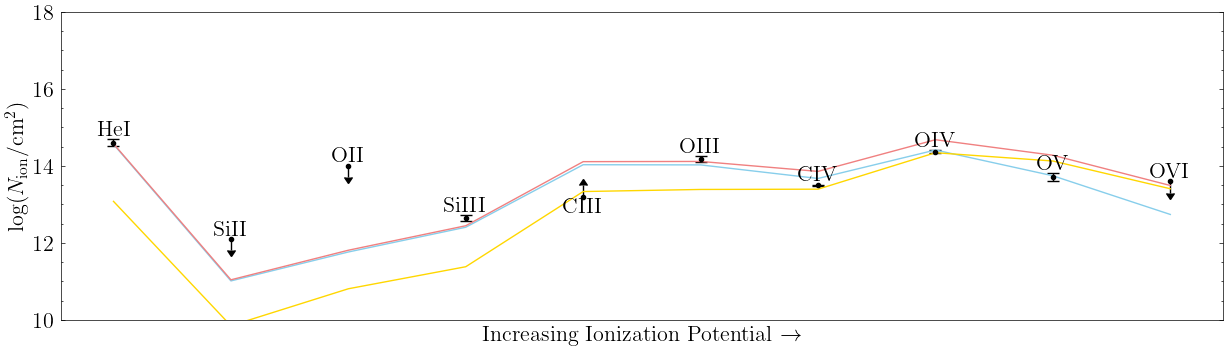

In [244]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [240]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, Si_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, Si_O_test_p2]) + 1e-7 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [204]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [205]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [206]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s]


In [207]:
flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'Si_O_p1',
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'Si_O_p2'])
flat_samples_two_phase.to_csv(savedir+'two_phase_CSi_c1.csv', index=False)

#flat_samples_two_phase = pd.read_csv(savedir+'two_phase_CSi_c1.csv')

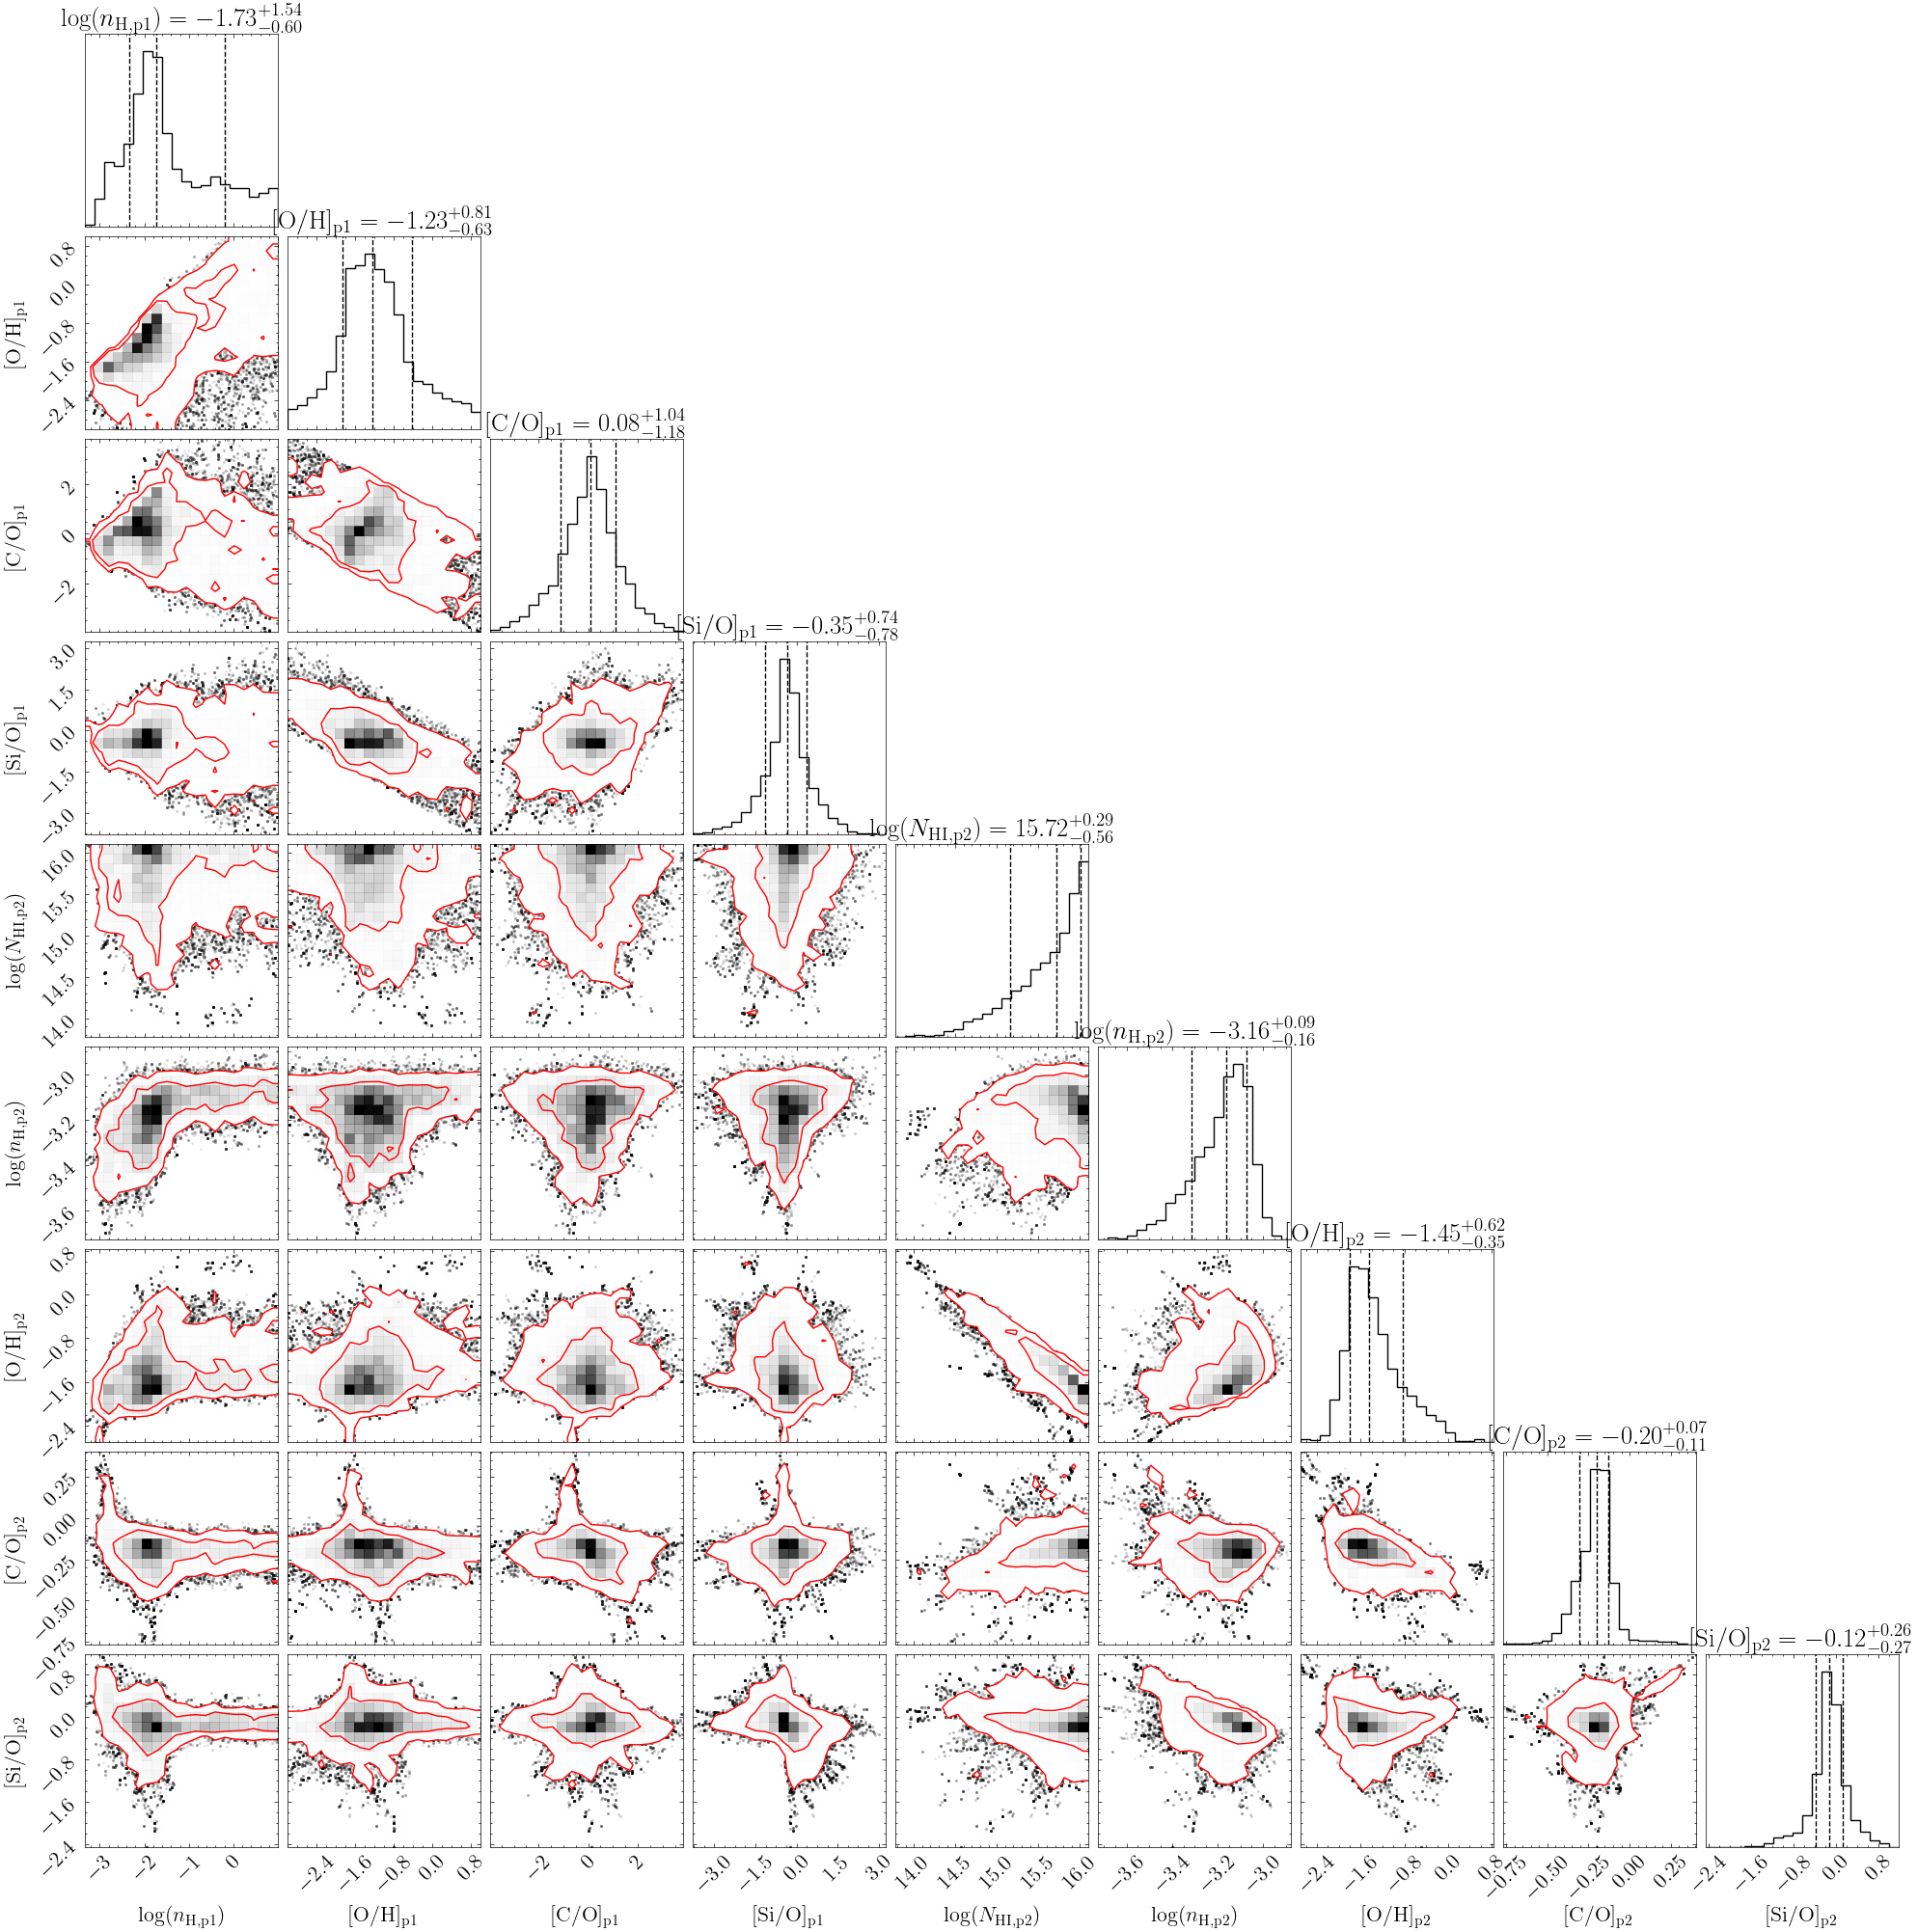

In [208]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{Si/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{Si/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [209]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            'HeI':'14.60, -0.09, +0.09',
            'CIII':'>13.2',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',
            'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [210]:
b_dict = {'HI':'19, -3, +2',
          'HeI':'12, -1, +1',
          'CIII': '11.0, -0.4, +0.4',
          'CIV': '11.0, -0.4, +0.4',
          'OIII': '14, -2, +3',
          'OIV': '16, -2, +2',
          'OV': '10, -3, +3',
          'SiIII': '11, -2, +2'}

In [211]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

In [212]:
z_sys = 1.16590953

In [213]:
import matplotlib.lines as mlines

(6.0, 25.0)

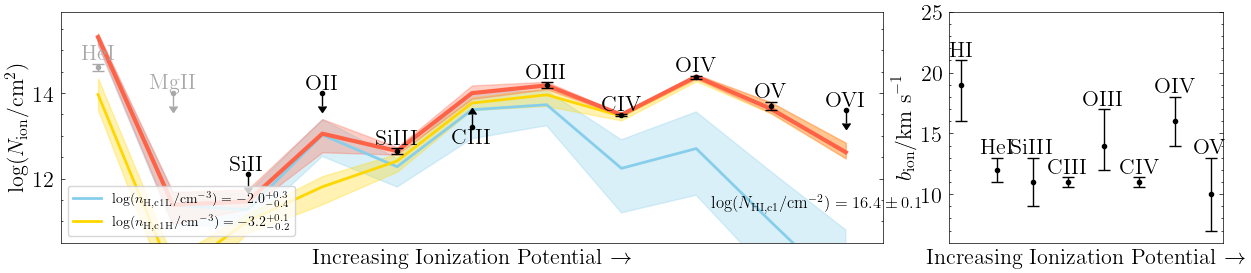

In [214]:
logN_species_p1_grid = np.zeros((len(logN_dict), len(sample_indices_two_phase)))
logN_species_p2_grid = np.zeros((len(logN_dict), len(sample_indices_two_phase)))
logN_species_grid = np.zeros((len(logN_dict), len(sample_indices_two_phase)))

fig, axes = plt.subplots(1, 2, figsize=(15,3), gridspec_kw={'width_ratios': [3, 1]})

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    C_O_p1 = flat_samples_row['C_O_p1']
    Si_O_p1 = flat_samples_row['Si_O_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    Si_O_p2 = flat_samples_row['Si_O_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, 
                                                     species_logN_interp,{'C':C_O_p1,
                                                                          'Si':Si_O_p1}))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, 
                                                     species_logN_interp, {'C':C_O_p2,
                                                                           'Si':Si_O_p2}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)
    
    logN_species_p1_grid[:,i] = logN_species_test_p1
    logN_species_p2_grid[:,i] = logN_species_test_p2
    logN_species_grid[:,i] = logN_species_test
    
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_species_test)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_species_test)), logN_species_med, color='tomato', lw=3, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axes[0],
                          gray_out = ['HeI', 'MgII', 'NeVIII'])

axes[0].set_ylim(10.5,15.9)

axes[0].text(8.2, 11.3, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 16.4 \pm 0.1$', fontsize=12)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -2.0_{-0.4}^{+0.3}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -3.2_{-0.2}^{+0.1}$'))
    
axes[0].legend(handles=handles, loc='lower left', fontsize=10)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_linewidth_obs(b_dict, fig, axes[1])
axes[1].set_ylim(6,25)
#ax.set_title('Two-phase decomposition for a CIV absorber', fontsize=18)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [276]:
l_p1 = np.zeros(len(flat_samples_two_phase))
l_p2 = np.zeros(len(flat_samples_two_phase))

In [277]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

Text(0, 0.5, 'Counts')

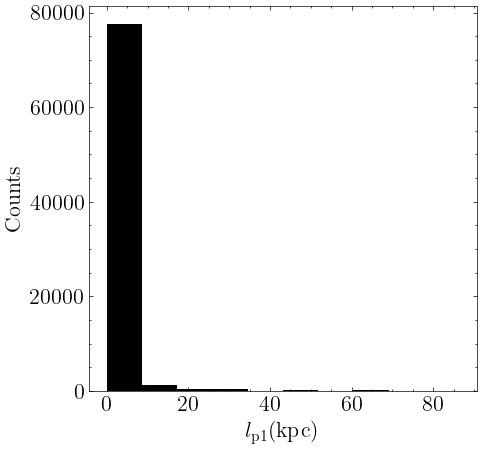

In [278]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [279]:
np.median(l_p1), np.percentile(l_p1, 100*cdf_3sig)

(0.1785817498412088, 72.5498740833838)

Text(0, 0.5, 'Counts')

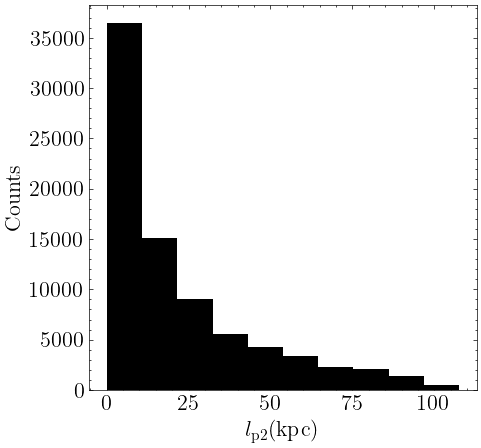

In [280]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [281]:
np.median(l_p2), np.percentile(l_p2, 100*cdf_3sig)

(12.953211463833242, 101.65285340721766)

# c1 - Two-phase solution: low density phase

In [15]:
logN_HI_test = 16.1
log_hdens_test = -3.8
log_metals_test = -2.75

In [16]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, 
                                     log_metals_test, species_logN_interp)

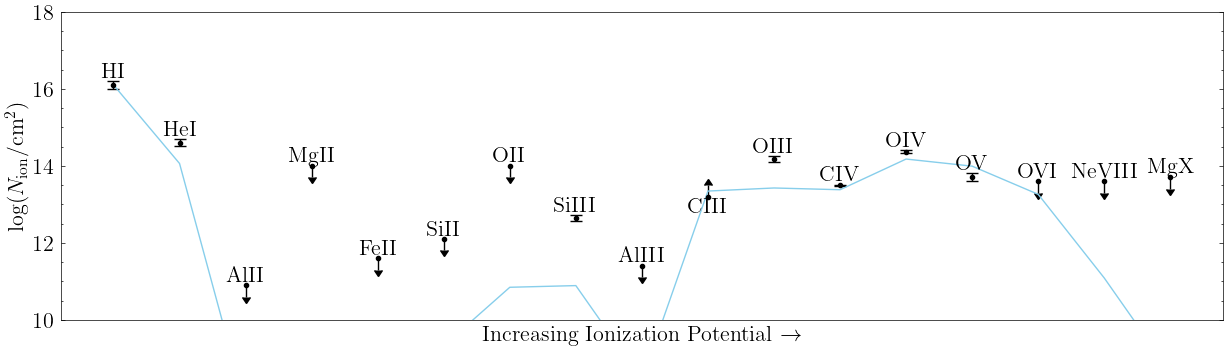

In [17]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

In [24]:
logN_dict = {'HI':'16.1, -0.1, +0.1',
            'HeI':'14.60, -0.09, +0.09',
            #'CIII':'>13.2',
            #'CIV':'13.49, -0.02, +0.02',
            #'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            #'OVI':'<13.6',}
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            #'SiII':'<12.1',
            'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [29]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [23]:
pos = np.array(-3.25) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [24]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [25]:
#sampler.run_mcmc(pos, 500, progress=True);

In [26]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo_c1.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo_c1.csv')

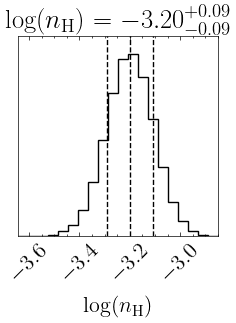

In [27]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [28]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [29]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OV, ref}}$')

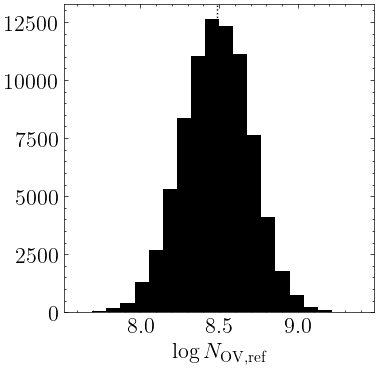

In [30]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+4'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+4'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

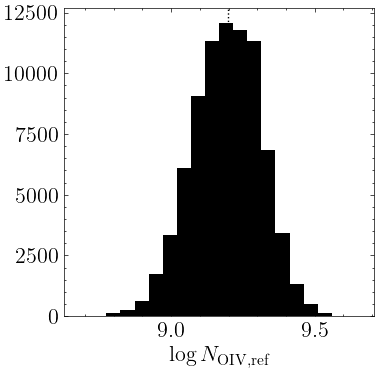

In [31]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{OIII, ref}}$')

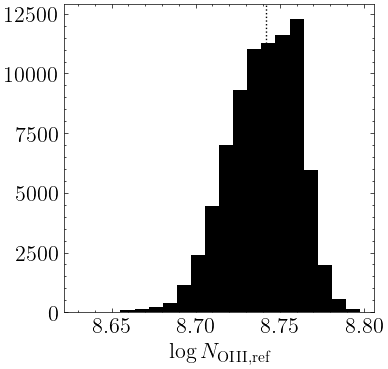

In [32]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{CIII, ref}}$')

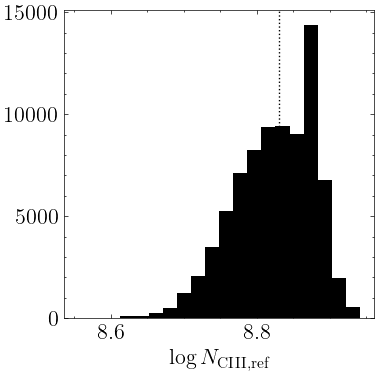

In [33]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [34]:
logN_offset = 14.37-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [35]:
logN_offset

5.172588136667381

Calculate the C/O ratio

In [36]:
logN_CIV_obs = np.random.normal(loc=13.49, scale=0.02, size=len(flat_samples_hdens))

In [37]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [38]:
get_quantiles(C_O_dist)

-0.1 -0.12 0.14


Get yields

In [39]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.91 -0.02 0.02


Plot models

In [40]:
logN_dict = {#'HI':'16.1, -0.1, +0.1',
            #'HeI':'14.60, -0.09, +0.09',
            'CIII':'>13.2',
            'CIV':'13.49, -0.02, +0.02',
            'OII':'<14.0',
            'OIII':'14.18, -0.07, +0.07',
            'OIV':'14.37, -0.04, +0.04',
            'OV':'13.7, -0.1, +0.1',
            'OVI':'<13.6',
            #'NeVIII':'<13.6',
            #'MgII':'<14.0',
            #'MgX':'<13.7',
            #'AlII':'<10.9',
            #'AlIII':'<11.4',
            'SiII':'<12.1',
            'SiIII':'12.64, -0.07, +0.07',}
            #'FeII':'<11.6',}

In [41]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

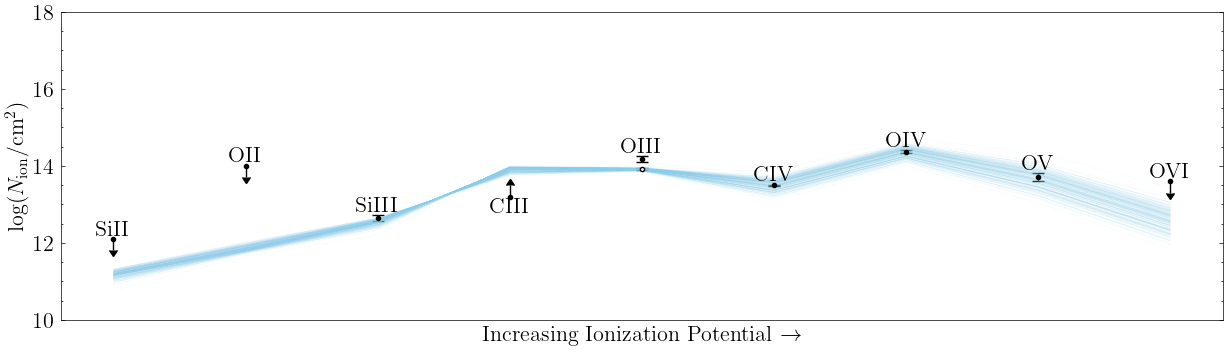

In [42]:
fig, ax = plot_column_densities_obs(logN_dict)

ax.errorbar(x=4, y=13.91, yerr=0.02, color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

#ax.errorbar(x=1, y=13.98, yerr=0.08, color='black', linestyle='None', mfc='white',
#        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp,
                                        {'C':np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for OIII

In [43]:
logN_OIII_tot = np.random.normal(loc=14.18, scale=0.07, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=13.91, scale=0.02, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

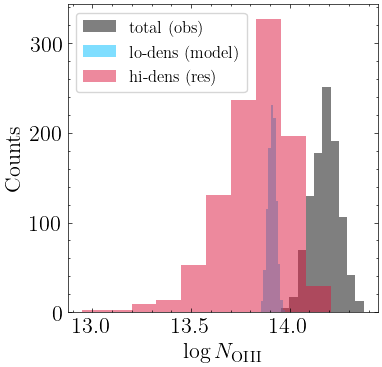

In [44]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [45]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [46]:
get_quantiles(logN_OIII_hi_dens_clean)

13.85 -0.19 0.13


# c2 - Higher density phase

In [334]:
def lambda_log_prior(params):

    # Grid parameters being varied
    log_hdens, log_metals = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    if -4<log_hdens<log_hdens_max and log_metals_min<log_metals<log_metals_max:
        return 0.0
    return -np.inf

In [335]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Only parameters being varied
    log_hdens, log_metals = params
    
    # Construct the full range of parameters
    # Empty dictionary means solar abundance patterns
    params_full = np.array([logN_HI_test, log_hdens, log_metals, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [336]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

Fit things

In [356]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            #'HeI':'<12.5',
            #'CIII':'<12.6',
            #'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            #'OIV':'13.8, -0.1, +0.1',
            #'OV':'13.83, -0.05, +0.05',
            #'OVI':'13.9, -0.1, +0.1',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'<11.7',}
            #'FeII':'<11.4',}

In [357]:
logN_HI_test = 14.5
log_hdens_test = -3.5
log_metals_test = -1

In [358]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp)

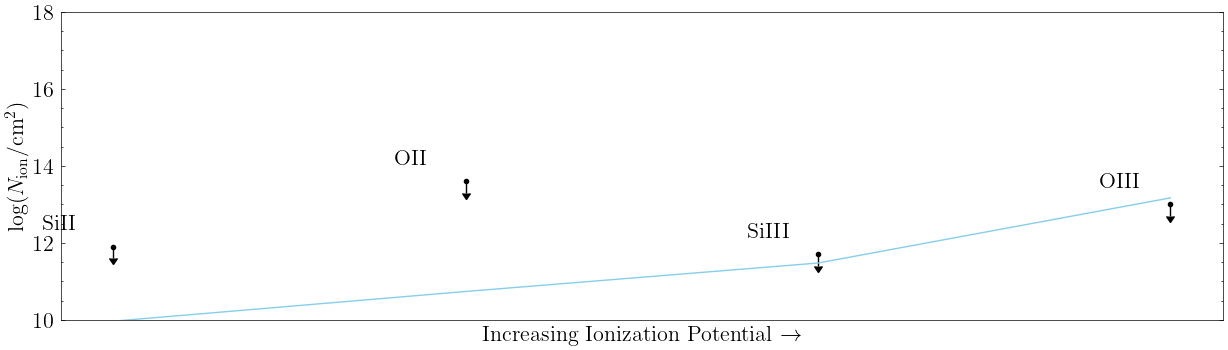

In [359]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='skyblue')

In [360]:
pos = np.array([-1, -1]) + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [361]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [362]:
#sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [01:23<00:00,  6.01it/s]


In [363]:
#flat_samples_hier_dens_1 = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals'])
#flat_samples_hier_dens_1.to_csv(savedir+'hdens_hier_c2.csv', index=False)

flat_samples_hier_dens_1 = pd.read_csv(savedir+'hdens_hier_c2.csv')

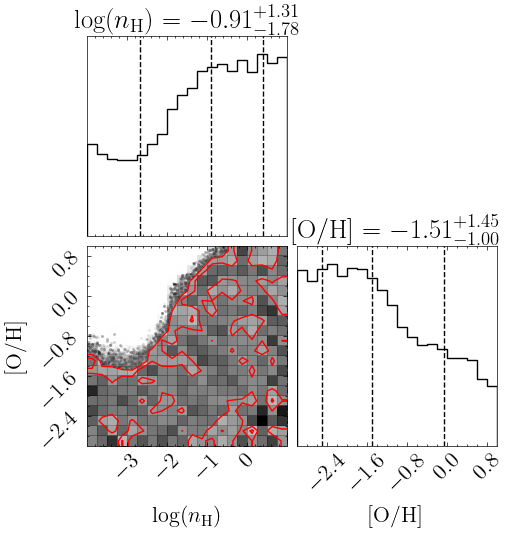

In [364]:
fig = corner.corner(
    flat_samples_hier_dens_1, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [365]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            'HeI':'<12.5',
            #'CIII':'<12.6',
            #'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            #'OIV':'13.8, -0.1, +0.1',
            #'OV':'13.83, -0.05, +0.05',
            #'OVI':'13.9, -0.1, +0.1',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'<11.7',}
            #'FeII':'<11.4',}

In [366]:
sample_indices_hier = np.random.randint(low=0, high=len(flat_samples_hier_dens_1), size=500)

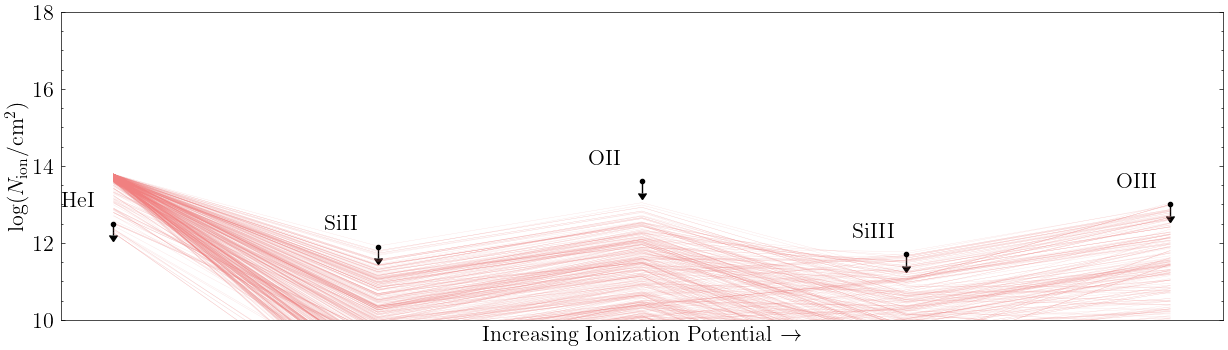

In [367]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hier)):
    
    idx = sample_indices_hier[i]
    flat_samples_row = flat_samples_hier_dens_1.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    log_metals = flat_samples_row['log_metals']
    
    logN_species_test = predict_col_dens(logN_dict,  logN_HI_test, log_hdens, log_metals, species_logN_interp)
    #logN_species_test[0] = 15.44

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.3)

# c2 - Two-phase solution

In [240]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [241]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [242]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [248]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            #'HeI':'<12.5',
            #'CIII':'<12.6',
            #'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            'OIV':'13.8, -0.1, +0.1',
            'OV':'13.83, -0.05, +0.05',
            'OVI':'<13.9',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',}
            #'SiIII':'<11.7'}
            #'FeII':'<11.4',}

In [261]:
logN_HI_test_p1 = 14.5
log_hdens_test_p1 = -1.5
log_metals_test_p1 = -1.8

logN_HI_test_p2 = 14.1
log_hdens_test_p2 = -3.9
log_metals_test_p2 = -0.9

In [262]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

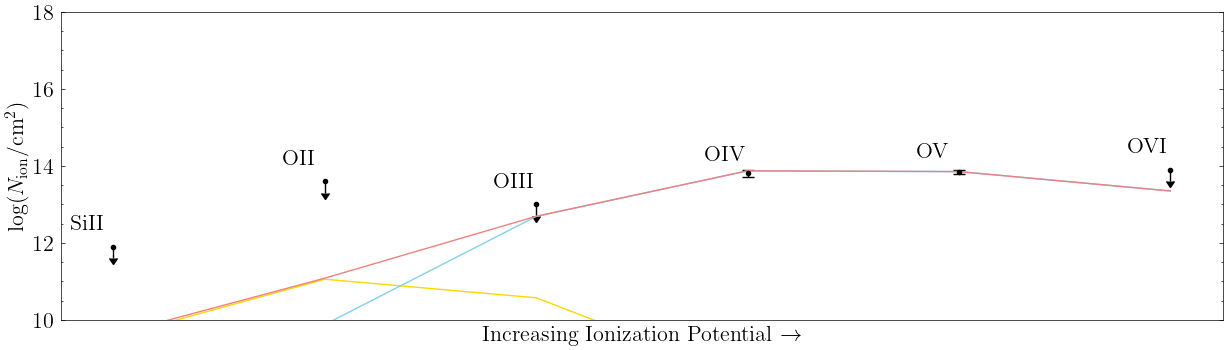

In [263]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [264]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-6 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [265]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [266]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [368]:
#sampler.run_mcmc(pos, 500, progress=True);

In [369]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c2.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c2.csv')

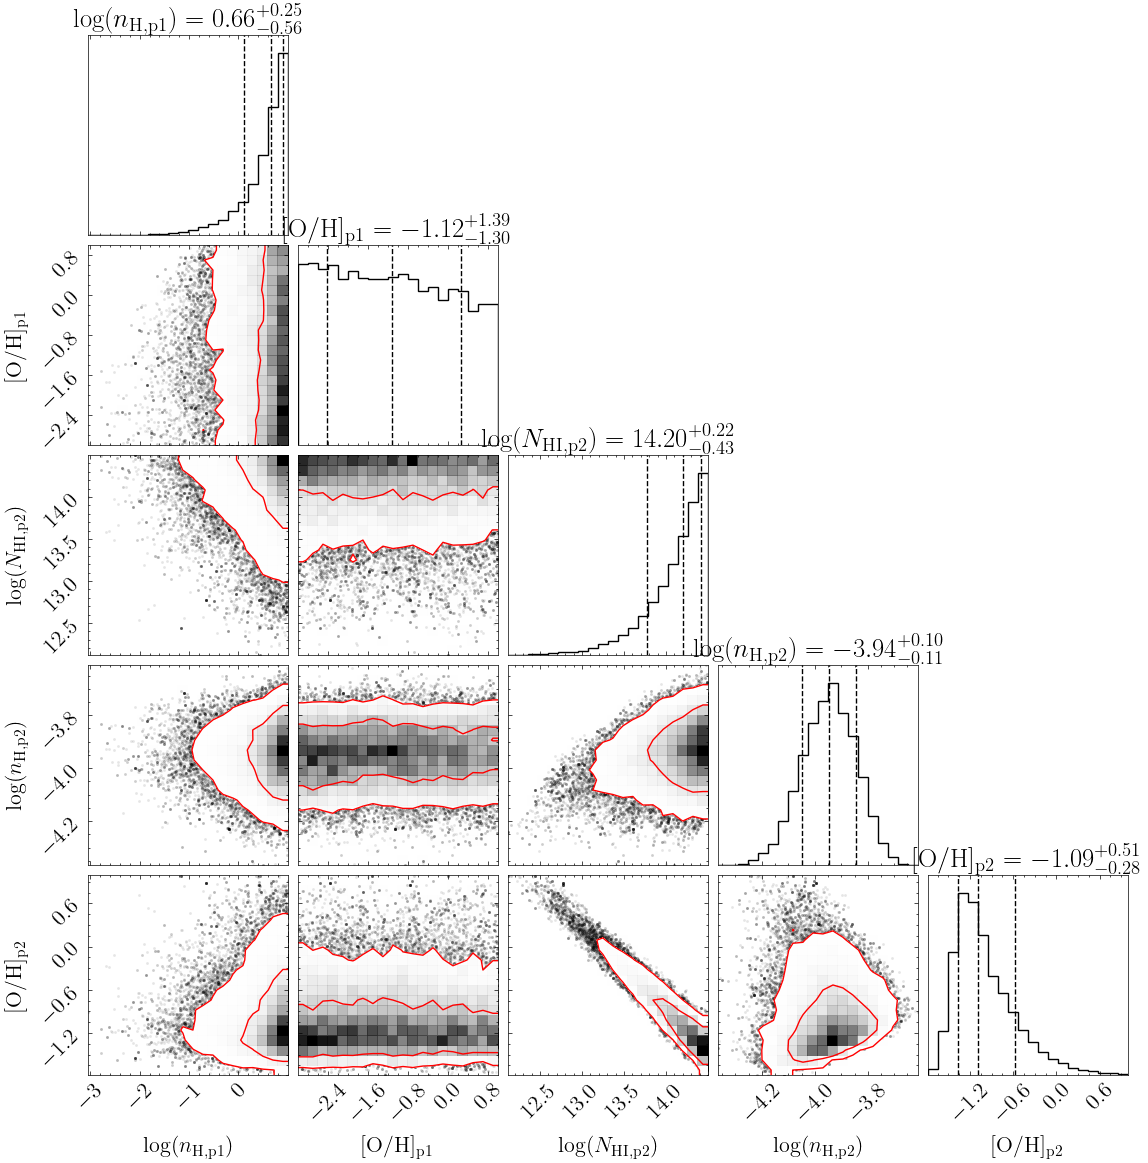

In [370]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [381]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            'HeI':'<12.5',
            'CIII':'<12.6',
            'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            'OIV':'13.8, -0.1, +0.1',
            'OV':'13.83, -0.05, +0.05',
            'OVI':'13.9, -0.1, +0.1',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'<11.7'}
            #'FeII':'<11.4',}

In [382]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

(10.0, 16.0)

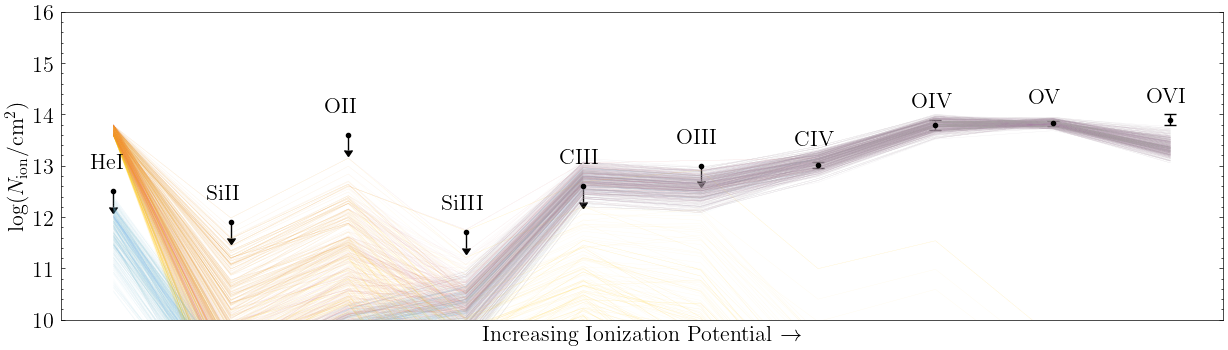

In [383]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

Get cloud sizes

In [273]:
l_p1 = np.zeros(len(flat_samples_two_phase))
l_p2 = np.zeros(len(flat_samples_two_phase))

In [274]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

Text(0, 0.5, 'Counts')

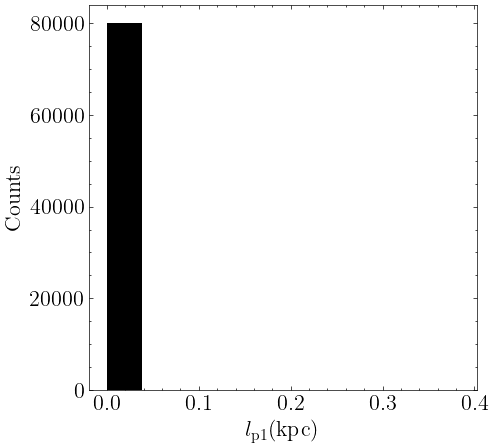

In [275]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [276]:
np.percentile(l_p1, 100*cdf_3sig)

0.0019722972240573235

Text(0, 0.5, 'Counts')

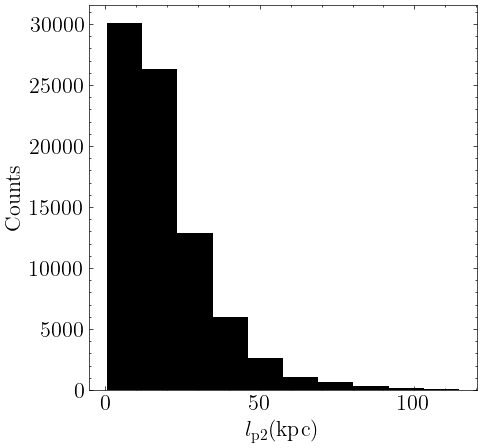

In [277]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [278]:
np.percentile(l_p2, 100*cdf_3sig)

99.81253471431296

# c2 - Two-phase solution (revisited)

In [384]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [385]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {'C':C_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [386]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [387]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            #'HeI':'<12.5',
            'CIII':'<12.6',
            'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            'OIV':'13.8, -0.1, +0.1',
            'OV':'13.83, -0.05, +0.05',
            'OVI':'<13.9',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'<11.7'}
            #'FeII':'<11.4',}

In [388]:
logN_HI_test_p1 = 14.5
log_hdens_test_p1 = -1.5
log_metals_test_p1 = -1.8

logN_HI_test_p2 = 14.1
log_hdens_test_p2 = -3.9
log_metals_test_p2 = -0.9
C_O_p2_test = -0.2

In [389]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test_p1, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp, {'C':C_O_p2_test}))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

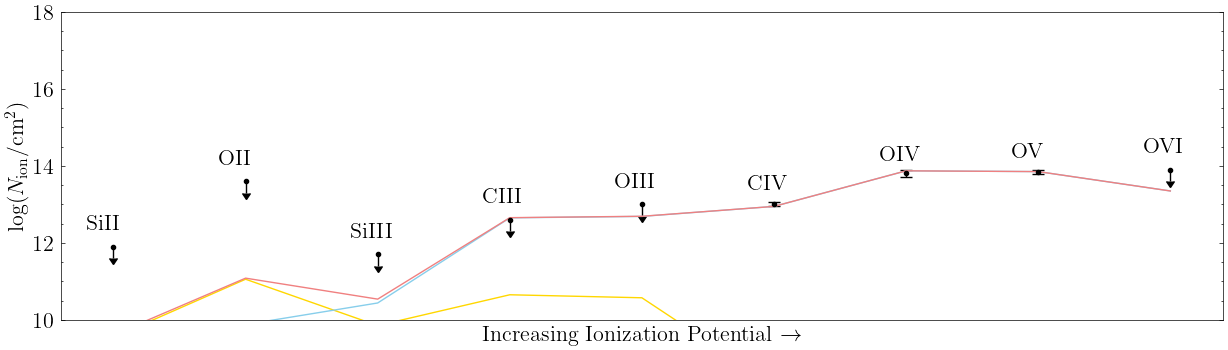

In [390]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [391]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2]) + 1e-6 * np.random.randn(200, 6)
nwalkers, ndim = pos.shape

In [392]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [393]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [394]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [05:13<00:00,  1.60it/s]


In [395]:
flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2'])
flat_samples_two_phase.to_csv(savedir+'two_phase_c2_C.csv', index=False)

#flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c2_C.csv')

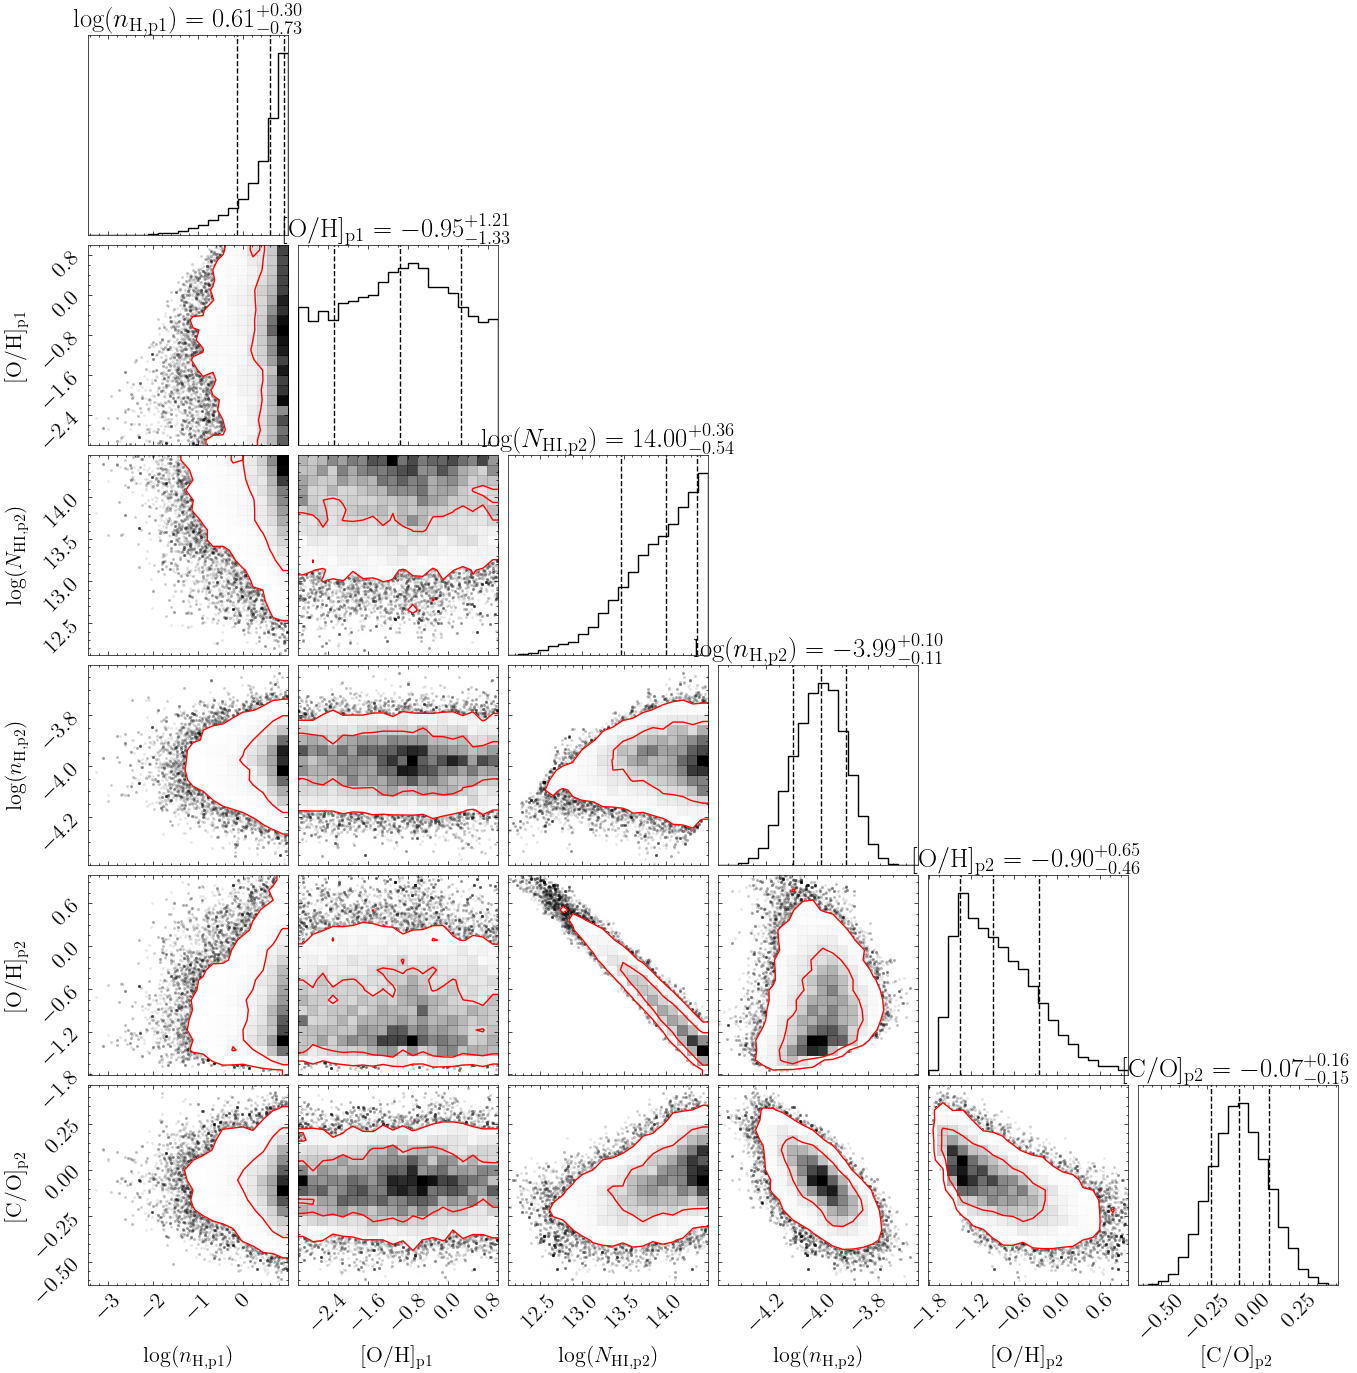

In [396]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [411]:
np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_3sig))

-2.296526178144571

In [412]:
np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_3sig)

0.9964006546577884

Now plot the best models

In [399]:
logN_dict = {#'HI':'14.5, -0.2, +0.2',
            'HeI':'<12.5',
            'CIII':'<12.6',
            'CIV':'13.01, -0.06, +0.06',
            'OII':'<13.6',
            'OIII':'<13.0',
            'OIV':'13.8, -0.1, +0.1',
            'OV':'13.83, -0.05, +0.05',
            'OVI':'13.9, -0.1, +0.1',
            #'NeVIII':'<13.4',
            #'MgII':'<14.0',
            #'MgX':'<13.5',
            #'AlII':'<10.7',
            #'AlIII':'<11.2',
            'SiII':'<11.9',
            'SiIII':'<11.7'}
            #'FeII':'<11.4',}

In [400]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

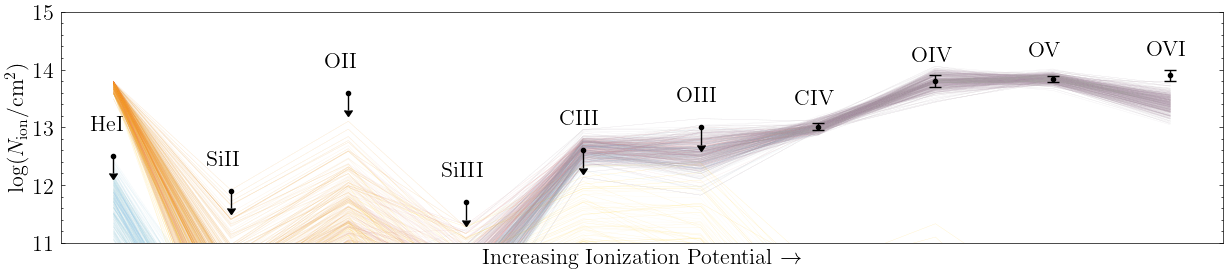

In [404]:
fig, ax = plt.subplots(1, figsize=(15,3))

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp, {'C':C_O_p2}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
plot_column_densities_obs(logN_dict, fig, ax)

ax.set_ylim(11,15)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [405]:
l_p1 = np.zeros(len(flat_samples_two_phase))
l_p2 = np.zeros(len(flat_samples_two_phase))

In [406]:
for i in range(len(l_p1)):
    
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    l_p1[i] = get_cloud_size(logN_HI_test, flat_samples_row['log_hdens_p1'], species_logN_interp)
    l_p2[i] = get_cloud_size(flat_samples_row['logN_HI_p2'], flat_samples_row['log_hdens_p2'], species_logN_interp)

Text(0, 0.5, 'Counts')

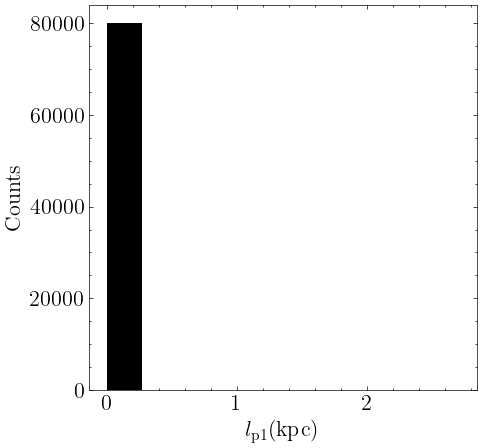

In [407]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p1, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p1}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [408]:
np.percentile(l_p1, 100*cdf_3sig)

0.00942150647912257

Text(0, 0.5, 'Counts')

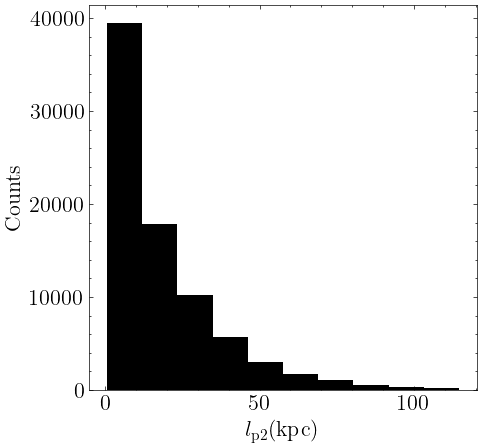

In [409]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(l_p2, bins=10)

ax.set_xlabel(r'$l_{\mathrm{p2}} (\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [410]:
np.percentile(l_p2, 100*cdf_3sig)

109.39824442567492

# c2 - Single phase density solution

In [42]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [48]:
logN_dict = {'HI':'14.7, -0.2, +0.2',
        'HeI':'<12.9',
        #'CIII':'<13.1',
        #'CIV':'13.02, -0.06, +0.06',
        #'OII':'<14.0',
        'OIII':'<13.4',
        'OIV':'13.8, -0.1, +0.1',
        'OV':'13.84, -0.05, +0.05',
        'OVI':'<13.9',}
        #'NeVIII':'<13.7',
        #'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.7',
        #'SiII':'<12.3',
        #'SiIII':'<12.2',
        #'FeII':'<11.8',}

Get column density ratios

In [49]:
gen_logN_ratio_str(logN_dict['HeI'], logN_dict['HI'])

'<-1.80, 0.24'

In [50]:
logN_ratio_dict = {'HeI/HI': '<-1.80, 0.24',
                   #'OIII/OIV': '<-0.4, 0.2',
                   'OV/OIV': '0.0, -0.1, 0.1',}
                   #'OVI/OV': '<0.1, 0.2'}

Generate predicted column density ratios

(-2.2, 2.0)

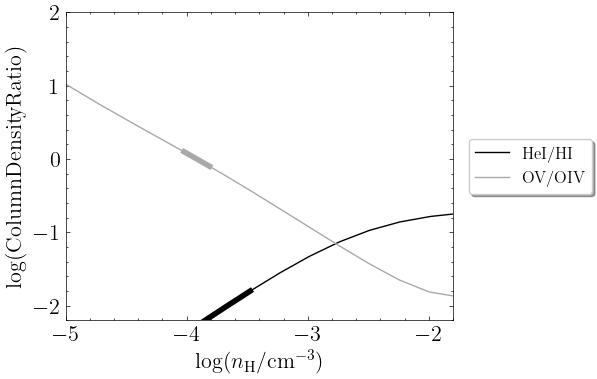

In [51]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2)

In [47]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [360]:
pos = np.array(-4) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [361]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [364]:
#sampler.run_mcmc(pos, 500, progress=True);

In [365]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo_c2.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo_c2.csv')

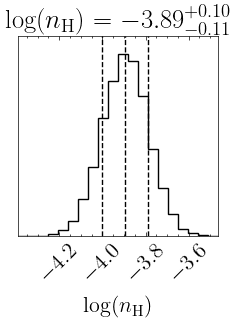

In [366]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [367]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [368]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

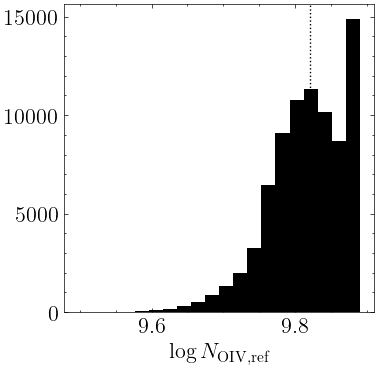

In [369]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [370]:
logN_offset = 13.8-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [371]:
logN_offset

3.979126398039652

Calculate the C/O ratio

In [372]:
logN_CIV_obs = np.random.normal(loc=13.02, scale=0.06, size=len(flat_samples_hdens))

In [373]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [374]:
get_quantiles(C_O_dist)

0.08 -0.06 0.07


Plot models

In [375]:
logN_dict = {#'HI':'14.7, -0.2, +0.2',
        #'HeI':'<12.9',
        'CIII':'<13.1',
        'CIV':'13.02, -0.06, +0.06',
        'OII':'<14.0',
        'OIII':'<13.4',
        'OIV':'13.8, -0.1, +0.1',
        'OV':'13.84, -0.05, +0.05',
        'OVI':'13.9, -0.1, +0.1',
        #'NeVIII':'<13.7',
        #'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.7',
        'SiII':'<12.3',}
        #'SiIII':'<12.2',
        #'FeII':'<11.8',}

In [376]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

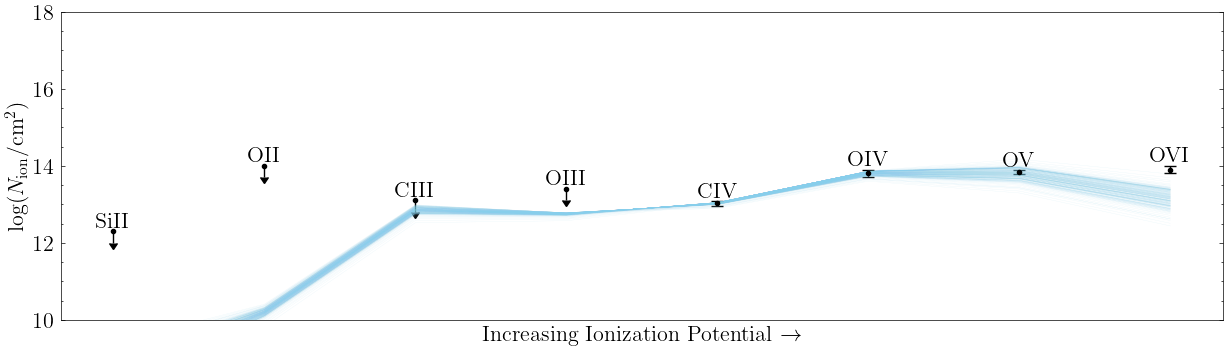

In [377]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp,
                                        {'C':np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

In [378]:
get_cloud_size(14.5, -3.9, species_logN_interp)

27.919265923980113

# c2 - Single phase density solution

In [42]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [48]:
logN_dict = {'HI':'14.7, -0.2, +0.2',
        'HeI':'<12.9',
        #'CIII':'<13.1',
        #'CIV':'13.02, -0.06, +0.06',
        #'OII':'<14.0',
        'OIII':'<13.4',
        'OIV':'13.8, -0.1, +0.1',
        'OV':'13.84, -0.05, +0.05',
        'OVI':'<13.9',}
        #'NeVIII':'<13.7',
        #'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.7',
        #'SiII':'<12.3',
        #'SiIII':'<12.2',
        #'FeII':'<11.8',}

## Two-phase solution

In [76]:
def lambda_log_prior_two_phase(params, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [77]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [78]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params, species_logN_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [79]:
logN_dict = {'HI':'14.7, -0.2, +0.2',
        'HeI':'<12.9',
        'CIII':'<13.1',
        'CIV':'13.02, -0.06, +0.06',
        'OII':'<14.0',
        'OIII':'<13.4',
        'OIV':'13.8, -0.1, +0.1',
        'OV':'13.84, -0.05, +0.05',
        'OVI':'<13.9',
        #'NeVIII':'<13.7',
        'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.7',
        'SiII':'<12.3',
        'SiIII':'<12.2',}
        #'FeII':'<11.8',}

In [80]:
logN_HI_test = 14.7
log_hdens_test_p1 = -3.4
log_metals_test_p1 = -2.0
C_O_test_p1 = -0.5

logN_HI_test_p2 = 13.6
log_hdens_test_p2 = -4.0
log_metals_test_p2 = -0.6
C_O_test_p2 = 0.0

In [81]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [82]:
get_cloud_size(logN_HI_test, log_hdens_test_p1, species_logN_interp, log_metals_test_p1)

3.470958509368953

In [83]:
get_cloud_size(logN_HI_test_p2, log_hdens_test_p2, species_logN_interp, log_metals_test_p2)

3.642528910672945

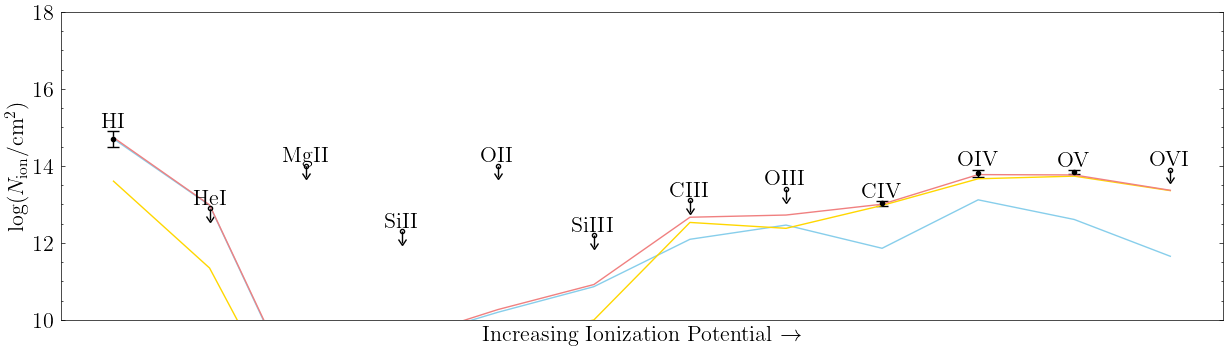

In [84]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [85]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2]) + 1e-4 * np.random.randn(200, 7)
nwalkers, ndim = pos.shape

In [86]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [87]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [88]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1',
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c2.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c2.csv')

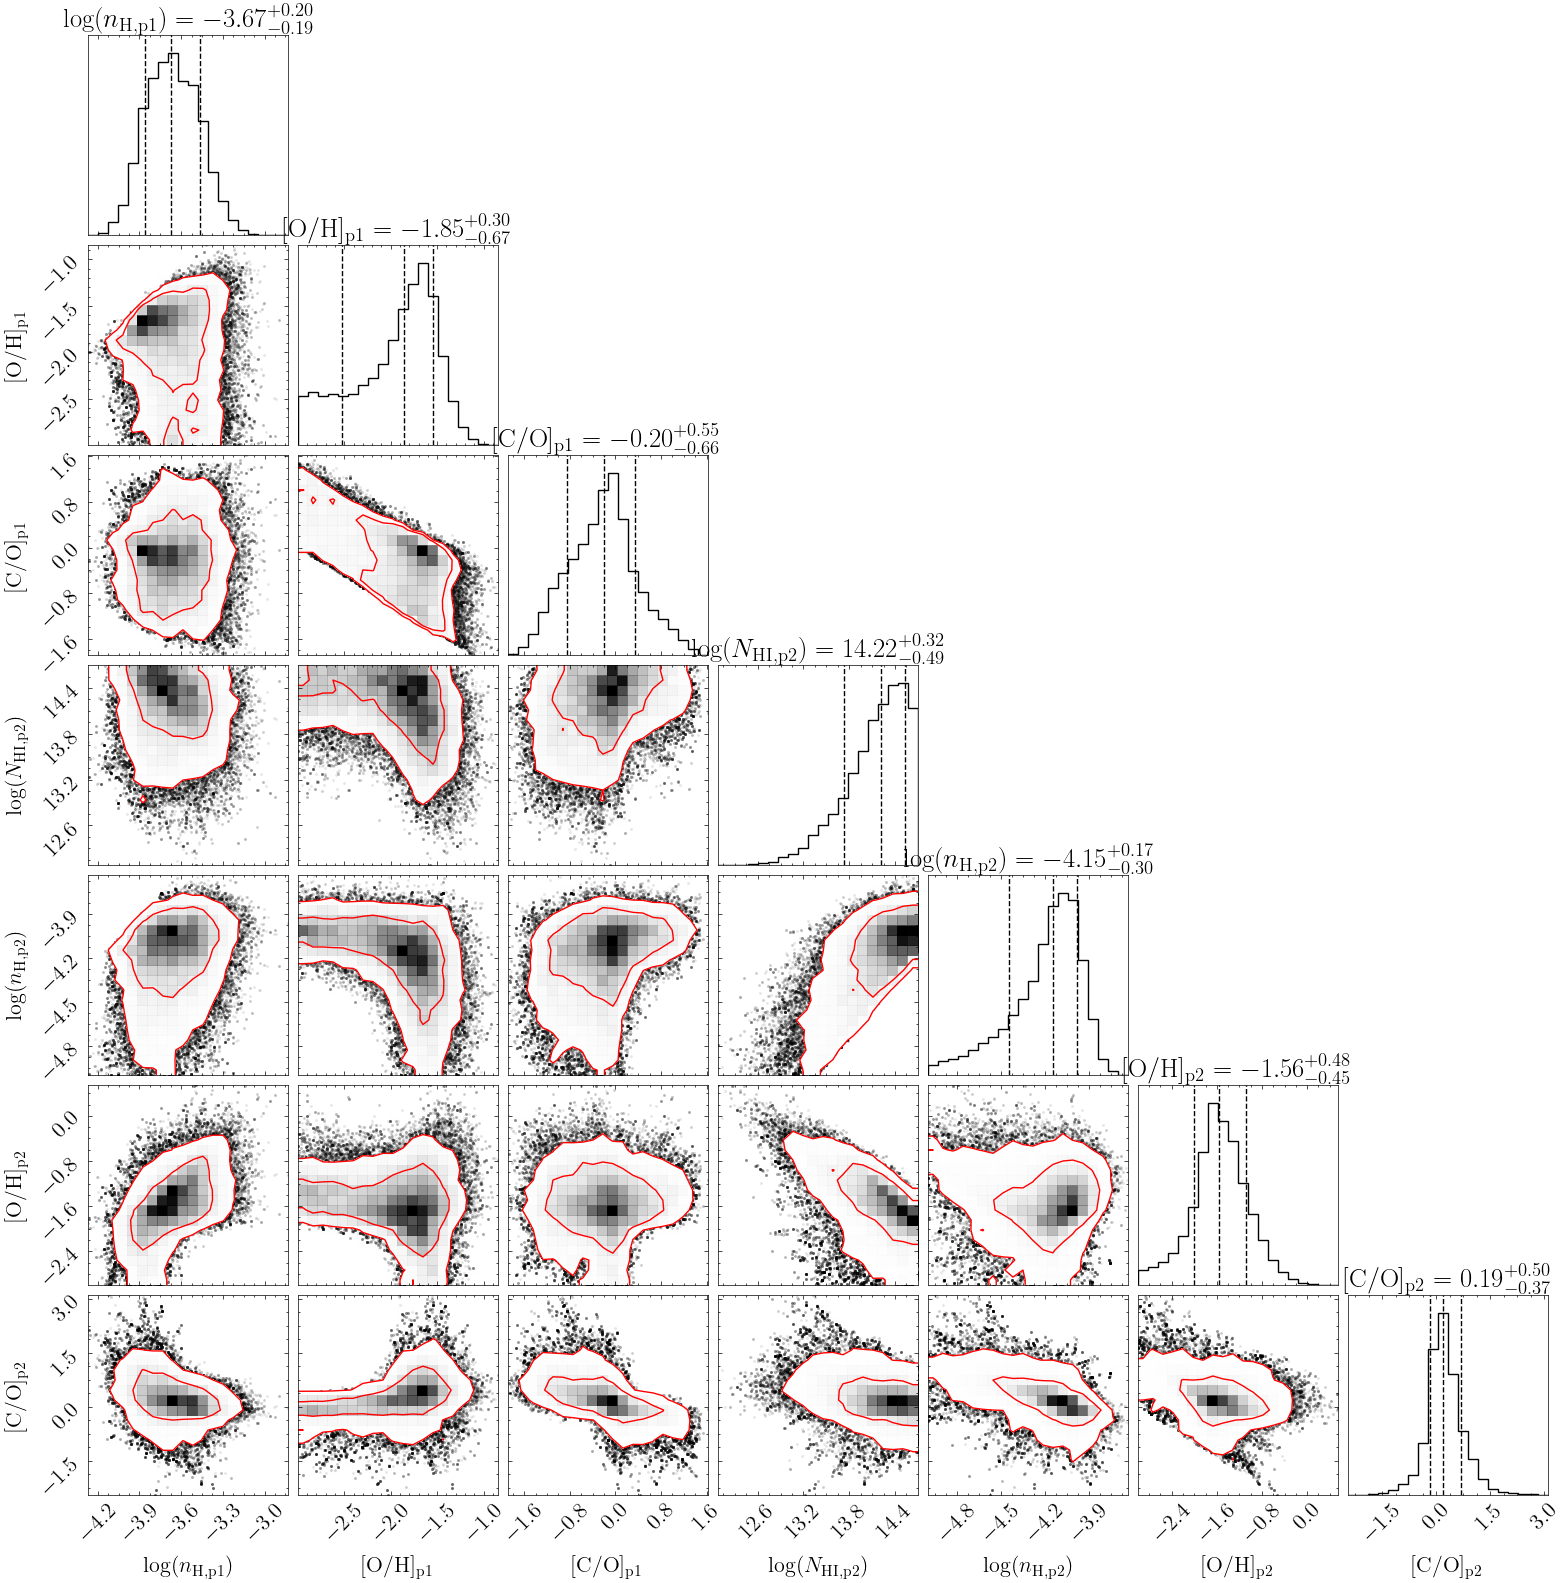

In [89]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [90]:
np.median(flat_samples_two_phase['log_hdens_p2'])

-4.14664086762453

In [91]:
np.percentile(flat_samples_two_phase['log_metals_p1'],100*cdf_3sig), np.percentile(flat_samples_two_phase['C_O_p1'],100*cdf_3sig)

(-1.0737025104297788, 1.3804667475448045)

In [92]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.613236691597924, 14.699312686514396)

In [93]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-2.984274210067691, 0.03333669588239327)

(array([  298.,  2093.,  9492., 27071., 48057., 48760., 30793., 12086.,
         1428.,   322.]),
 array([-3.32355073, -2.57623954, -1.82892834, -1.08161715, -0.33430595,
         0.41300524,  1.16031643,  1.90762763,  2.65493882,  3.40225002,
         4.14956121]),
 <BarContainer object of 10 artists>)

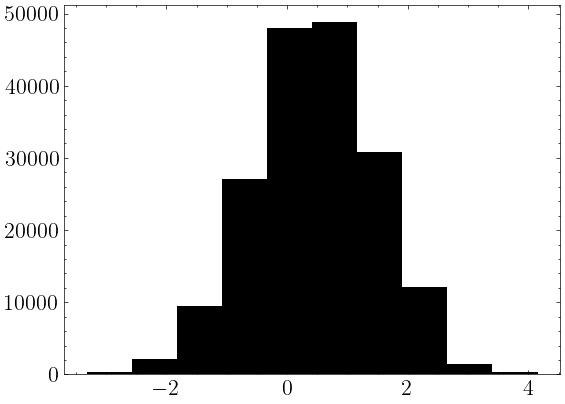

In [94]:
plt.hist(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'])

In [95]:
np.percentile(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'], 100*(1-cdf_3sig))

-2.6679627225449543

Now plot the best models

In [96]:
logN_dict = {#'HI':'14.7, -0.2, +0.2',
        'HeI':'<12.9',
        'CIII':'<13.1',
        'CIV':'13.02, -0.06, +0.06',
        #'OII':'<14.0',
        'OIII':'<13.4',
        'OIV':'13.8, -0.1, +0.1',
        'OV':'13.84, -0.05, +0.05',
        'OVI':'13.9, -0.1, +0.1',}
        #'NeVIII':'<13.7',
        #'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.7',
        #'SiII':'<12.3',
        #'SiIII':'<12.2',}
        #'FeII':'<11.8',}

In [97]:
b_dict = {'HI':'32, -3, +3',
          'CIV': '27, -3, +3',
          'OIV': '27, -6, +7',
          'OV': '28, -3, +2',
          'OVI': '45, -10, +17'}

In [98]:
z_sys = 1.16590953

In [99]:
import matplotlib.lines as mlines

In [100]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':0.})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':0.})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [101]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [104]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['CIII'] = '<0.22'
logN_res_up['OIII'] = '<0.22'
logN_res_up['OVI'] = '<0.22'

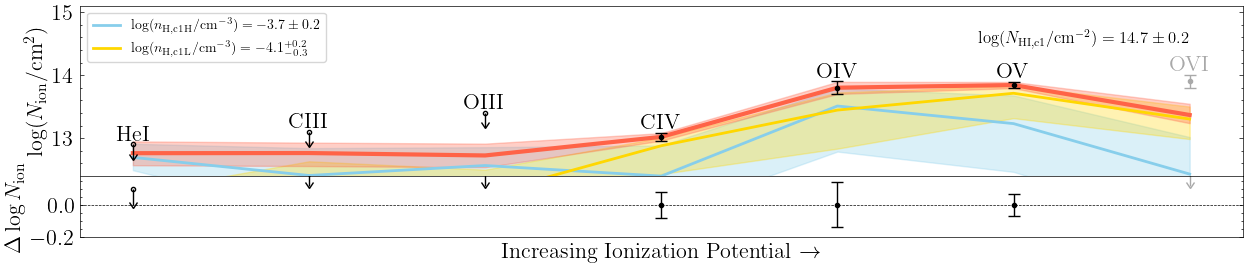

In [105]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axes[0],
                          gray_out = ['OVI', 'NeVI', 'NeVIII'], dy=.15)

axes[0].set_ylim(12.4,15.1)

axes[0].text(len(logN_dict)-1, 14.5, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.7 \pm 0.2$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -3.7 \pm 0.2$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -4.1_{-0.3}^{+0.2}$'))
    
axes[0].legend(handles=handles, loc='upper left', fontsize=10)

plot_column_densities_obs(logN_res_dict, fig, axes[1], gray_out = ['OVI', 'NeVI', 'NeVIII'], label_ions=False, dy=.08, c_dy=1.3)
plot_column_densities_obs(logN_res_up, fig, axes[1], gray_out = ['OVI', 'NeVI', 'NeVIII'], label_ions=False, dy=.08, c_dy=1.3)

axes[1].set_ylim(-.2,.18)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_tp.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [162]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

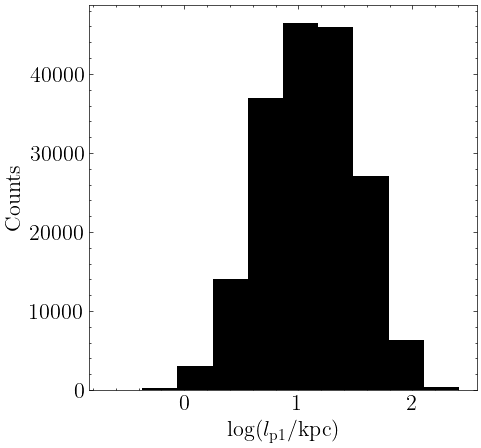

In [163]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [164]:
get_quantiles(np.log10(l_p1))

1.11 -0.44 0.41


In [165]:
np.percentile(np.log10(l_p1), 100*cdf_3sig)

2.12096231530919

Text(0, 0.5, 'Counts')

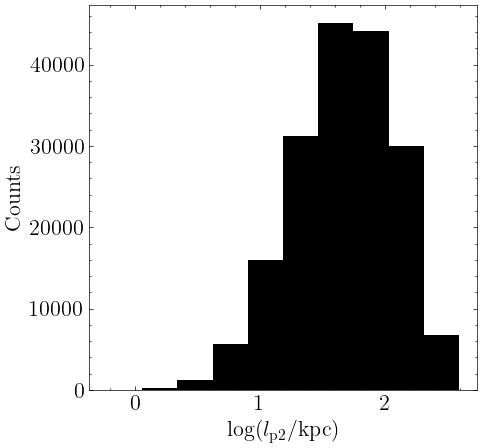

In [166]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

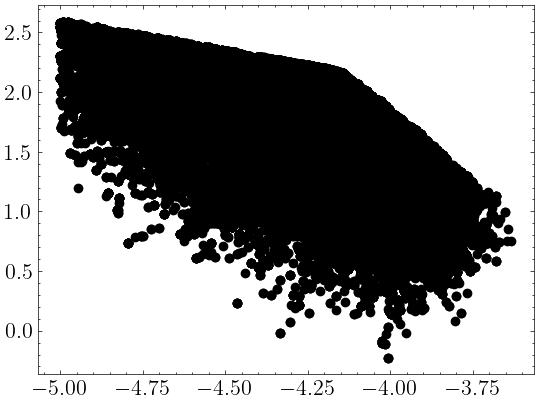

In [167]:
plt.scatter(flat_samples_two_phase['log_hdens_p2'], np.log10(l_p2))

In [168]:
get_quantiles(np.log10(l_p2))

1.69 -0.44 0.4


In [169]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(0.34644530020750963, 2.542055264890671)

In [144]:
np.log10(0.03*(10**-4.1/10**-3)**-1), np.log10(40*(10**-4.1/10**-3)**-0.5)

(-0.422878745280338, 2.1520599913279623)

In [145]:
np.log10(40*(10**-4.3/10**-3)**-0.5), np.log10(40*(10**-4.3/10**-3)**-0.5), np.log10(40*(10**-4.08/10**-3)**-0.5)

(2.2520599913279624, 2.2520599913279624, 2.1420599913279625)

In [90]:
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':0})

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [91]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [92]:
logN_res_up = {k:'<0.9' for k in list(logN_res_dict.keys())}

logN_res_up['SiII'] = '<0.45'
logN_res_up['OVI'] = '<0.45'

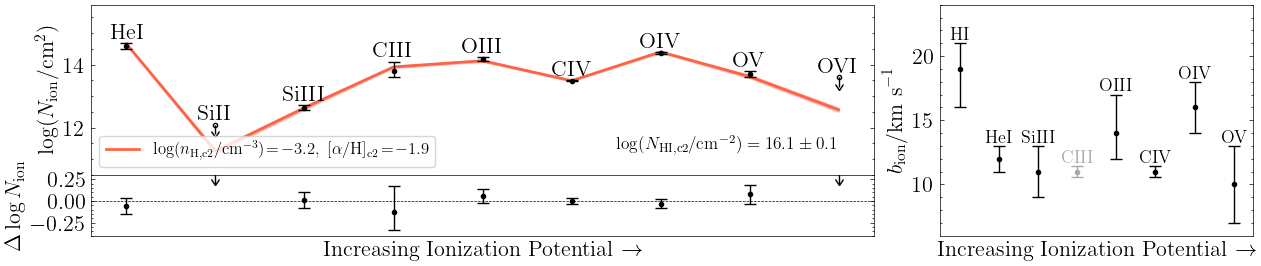

In [94]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})
axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=2, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['NeVIII'])

axd['upper left'].set_ylim(10.5,15.9)

axd['upper left'].text(len(logN_dict)-1, 11.3, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 16.1 \pm 0.1$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2}/\mathrm{cm}^{-3}) \!=\! -3.2, \ \mathrm{[\alpha/H]_{c2}} \!=\! -1.9$'))

axd['upper left'].legend(handles=handles, loc='lower left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['NeVIII'], label_ions=False)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['NeVIII'], label_ions=False, c_dy=1.3)

axd['lower left'].set_ylim(-.4,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], gray_out = ['CIII'], fs=13)
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(6,24)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [63]:
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':0})

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [64]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [65]:
logN_res_dict

{'HeI': '<1.5',
 'CIII': '<0.3',
 'OIII': '<0.8',
 'CIV': '0.0, -0.08, 0.08',
 'OIV': '0.0, -0.14, 0.14',
 'OV': '-0.0, -0.07, 0.07',
 'OVI': '0.63, -0.15, 0.14'}

In [66]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['HeI'] = '<0.3'
logN_res_up['OIII'] = '<0.3'
logN_res_up['OVI'] = '<0.3'

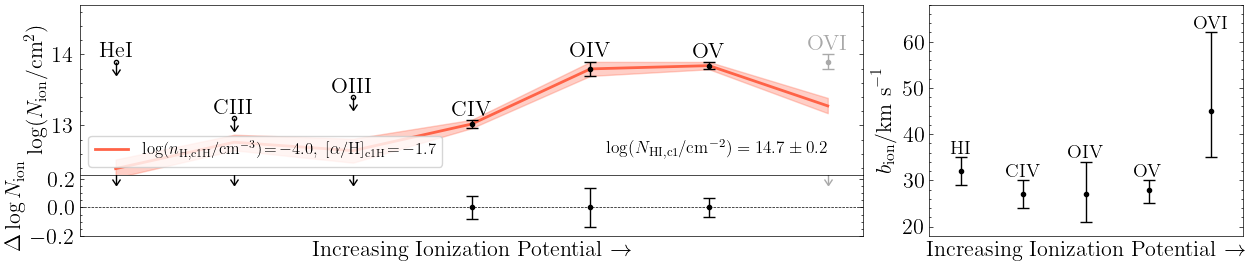

In [68]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=2, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI'], dy=.1, c_dy=1.7)

axd['upper left'].set_ylim(12.3,14.7)

axd['upper left'].text(len(logN_dict)-1, 12.6, 
             r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.7 \pm 0.2$', fontsize=12.5,
             horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) \!=\! -4.0, \ \mathrm{[\alpha/H]_{c1H}} \!=\! -1.7$'))

axd['upper left'].legend(handles=handles, loc='lower left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0) 

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.1, c_dy=1.4)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.1, c_dy=1.4)

axd['lower left'].set_ylim(-.2,.23)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=14)
axd['right'].set_xlim(-0.5, len(b_dict)-1+.5)
axd['right'].set_ylim(18,68)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)